<a href="https://colab.research.google.com/github/ElahehSadeghabadi/Deep-STMIA/blob/main/Baselines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simulations of the **Deep-STMIA** model, an E2E learning-based model for multi-user MISO BC systems with imperfect CSIT proposed in the following paper:

[1] E. Sadeghabadi and S. Blostein, **Unified Space-Time-Message Interference Alignment: An End-to-End Learning Approach,** *submitted to MDPI Entropy*, December 2025.

**Instruction:** First run Sections 0-6, then you can skip to any of the Sections 7-11.

# 0. Setup

In [ ]:
import random as rd

import numpy as np
import tensorflow as tf
from math import ceil, log, log2, sqrt, floor
import cvxpy as cp
from scipy.linalg import null_space

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# setting seeds for reproducibility
tf.random.set_seed(14)
tf.keras.utils.set_random_seed(14)

# Resetting the name counters
tf.keras.backend.clear_session()

In [ ]:
# --- Required layers ---
Input = tf.keras.layers.Input
Lambda = tf.keras.layers.Lambda
Layer = tf.keras.layers.Layer
Flatten = tf.keras.layers.Flatten
Concatenate = tf.keras.layers.Concatenate
Dense = tf.keras.layers.Dense
Model = tf.keras.Model

# 1. Generating Message Indices and Binary or One-Hot Encoding Representation

In [ ]:
# --- Parameters ---
bit_per_symbol = 4
n_samples = 10
M = 2**bit_per_symbol

# --- Generate Random Message Indices (0 to M-1) ---
messages_indices = np.random.randint(low=0, high=M, size=n_samples, dtype=np.int32)
messages_indices

array([11,  8, 12,  6,  7,  9,  6, 10, 12, 10], dtype=int32)

One-hot encoding:

In [ ]:
messages_one_hot = tf.one_hot(messages_indices, depth=2**bit_per_symbol)
messages_one_hot

<tf.Tensor: shape=(10, 16), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
      dtype=float32)>

Representing indices by $k$ binary bits or converting binary bits to indices:

In [ ]:
def binary_encoding(x,k):
    """
    It represents each element of x in its binary representation with k bits.
    !Important: k must be less than or equal to 8.

    Args:
      x: Input vector of integers from 0 to 2^k-1
      k: Number of bits to represent each element of x.

    Returns:
      Tensor with binary representation of each element of x.
    """
    y = np.zeros((x.shape[0],k))
    for i in range(x.shape[0]):
        y[i] = np.unpackbits(np.array(x[i],np.uint8))[-k:]
    return y

def binary_decoding(y,k):
    """
    Each row of x represents a number with k bits. This method transforms each row of x to its decimal representation.
    !Important: k must be less than or equal to 8.

    Args:
      x: Input vector of shape (...,k) with 0 and 1 values.
      k: Number of bits and the length of axis = 1 of x.

    Returns:
      Tensor with decimal representation of each row of x.
    """
    x = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        x[i] = np.packbits(np.concatenate([np.zeros(8-k,dtype = np.uint8),np.array(y[i],np.uint8)], axis = 0))[0]
    return x.astype(int)

In [ ]:
# Example:
x = messages_indices
k = 5
y = binary_encoding(x,k)
# Paking bits to integers:
x_hat = binary_decoding(y,k)
print(x)
print(y)
print(x_hat)

[11  8 12  6  7  9  6 10 12 10]
[[0. 1. 0. 1. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 1. 1. 1.]
 [0. 1. 0. 0. 1.]
 [0. 0. 1. 1. 0.]
 [0. 1. 0. 1. 0.]
 [0. 1. 1. 0. 0.]
 [0. 1. 0. 1. 0.]]
[11  8 12  6  7  9  6 10 12 10]


# 2. Modulation and Demodulation

## 3.1. BPSK Modulation and Demodulation

In [ ]:
def encoding_BPSK_lookup(x):
    """
    BPSK Modulator using an optimized Gray-coded lookup table.
    """

    bpsk_mapping = np.array([
        [-1,0], # bit 0 is 1+j0
        [1,0] # bit 1 is -1+j0
    ], dtype = np.float32)

    # Look up the I and Q values using the symbol index x
    mapped_IQ = bpsk_mapping[x]

    return mapped_IQ

In [ ]:
def decoding_BPSK_hard(received_IQ):
    """
    Hard-decision BPSK Demodulator (Decodes I-component only).

    Input: received_IQ array of shape (N, 2)
    Output: Decoded binary array of shape (N, 1)
    """
    # BPSK uses the I-component (first column) for the decision
    I_component = received_IQ[:, 0]

    # Decision Rule: I >= 0 maps to bit 1; I < 0 maps to bit 0
    # np.where returns the indices where the condition is True/False
    decoded_bits = np.where(I_component >= 0, 1, 0)

    return decoded_bits.reshape(-1, 1)

In [ ]:
# --- Example Usage ---
bit_per_symbol = 1 # binary
n_samples = 10
M = 2**bit_per_symbol

# --- Generate Random Message Indices (0 to M-1) ---
messages_indices = np.random.randint(low=0, high=M, size=n_samples, dtype=np.int32)

messages_indices

# Modulation
messages_bpsk = encoding_BPSK_lookup(messages_indices)
print('BPSK Modulation')
print(messages_bpsk)

# Demodulation
decoded_messages_bpsk = decoding_BPSK_hard(messages_bpsk)
decoded_indices = binary_decoding(decoded_messages_bpsk,bit_per_symbol)
print('BPSK Demodulation')
print(decoded_indices)
print(messages_indices)

BPSK Modulation
[[-1.  0.]
 [ 1.  0.]
 [-1.  0.]
 [ 1.  0.]
 [-1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [-1.  0.]
 [ 1.  0.]
 [-1.  0.]]
BPSK Demodulation
[0 1 0 1 0 1 1 0 1 0]
[0 1 0 1 0 1 1 0 1 0]


## 3.2. 4-QAM with Gray Mapping Modulation and Demodulation

In [ ]:
def encoding_4QAM_gray_lookup(x):
    """
    4-QAM Modulator using an optimized Gray-coded lookup table.
    """

    # Gray-coded Mapping Table (4 rows, 2 columns [I, Q])
    unnormalized_mapping = np.array([
        # I-component changes quickly (Gray) | Q-component is constant for the row
        [-1, -1], [-1, 1], # I level is 0 (i.e., -1)
        [1, -1], [1, 1], # I level is 1 (i.e., 1)
    ])

    # Look up the I and Q values using the symbol index x
    mapped_IQ = unnormalized_mapping[x]

    # Apply Normalization Factor (Divide by sqrt(Average Energy per Symbol = 2))
    norm_factor = np.sqrt(2)
    normalized_IQ = mapped_IQ / norm_factor

    return normalized_IQ

In [ ]:
def decoding_4QAM_gray_hard(received_IQ):
    """
    Hard-decision 4-QAM (QPSK) Demodulator using boundaries at I=0, Q=0.

    Input: received_IQ array of shape (N, 2)
    Output: Decoded binary array of shape (N, 2)
    """
    I_comp = received_IQ[:, 0]
    Q_comp = received_IQ[:, 1]

    # 1. Hard Decisions on I and Q
    # If I > 0, the unnormalized level is +1. If I < 0, level is -1.
    # From your mapping: +1 is 0, -1 is 1. (I >= 0 -> bit 1, I < 0 -> bit 0)
    # The encoder mapping: (1, 1) is 00, (-1, 1) is 01

    b0_i = np.where(I_comp >= 0, 1, 0)
    b1_q = np.where(Q_comp >= 0, 1, 0)

    decoded_bits = np.stack([b0_i, b1_q], axis=1)

    return decoded_bits

In [ ]:
# --- Example Usage ---
bit_per_symbol = 2
n_samples = 10
M = 2**bit_per_symbol

# --- Generate Random Message Indices (0 to M-1) ---
messages_indices = np.random.randint(low=0, high=M, size=n_samples, dtype=np.int32)

messages_indices

# Modulation
messages_4qam = encoding_4QAM_gray_lookup(messages_indices)
print('4-QAM Modulation')
print(messages_4qam)

# Demodulation
decoded_messages_4qam = decoding_4QAM_gray_hard(messages_4qam)
decoded_indices = binary_decoding(decoded_messages_4qam,bit_per_symbol)
print('4-QAM Demodulation')
print(decoded_indices)
print(messages_indices)

4-QAM Modulation
[[ 0.70710678  0.70710678]
 [-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]
 [ 0.70710678 -0.70710678]
 [-0.70710678 -0.70710678]
 [ 0.70710678 -0.70710678]
 [-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
4-QAM Demodulation
[3 0 1 2 2 0 2 0 1 1]
[3 0 1 2 2 0 2 0 1 1]


## 3.3. 16-QAM with Gray Mapping Modulation and Demodulation

In [ ]:
def encoding_16QAM_gray_lookup(x):
    """
    16-QAM Modulator using an optimized Gray-coded lookup table.
    """

    # Gray-coded Mapping Table (16 rows, 2 columns [I, Q])
    unnormalized_mapping = np.array([
        # I-component changes quickly (Gray) | Q-component is constant for the row
        [-3, -3], [-3, -1], [-3, 3], [-3, 1], # I level is 00 (e.g., -3)
        [-1, -3], [-1, -1], [-1, 3], [-1, 1], # I level is 01 (e.g., -1)
        [ 3, -3], [ 3, -1], [ 3, 3], [ 3, 1], # I level is 10 (e.g., 3)
        [ 1, -3], [ 1, -1], [ 1, 3], [ 1, 1]  # I level is 11 (e.g., 1)
    ])

    # Look up the I and Q values using the symbol index x
    mapped_IQ = unnormalized_mapping[x]

    # Apply Normalization Factor (Divide by sqrt(Average Energy per Symbol = 10))
    norm_factor = np.sqrt(10)
    normalized_IQ = mapped_IQ / norm_factor

    return normalized_IQ

In [ ]:
def decoding_16QAM_gray_hard(received_IQ):
    """
    Hard-decision 16-QAM Demodulator (based on boundaries at 0, +/- 2).

    Input: received_IQ array of shape (N, 2)
    Output: Decoded binary array of shape (N, 4)
    """
    # The normalization factor must be undone before decision boundaries are applied
    norm_factor = np.sqrt(10)
    unnormalized_IQ = received_IQ * norm_factor

    I_comp = unnormalized_IQ[:, 0]
    Q_comp = unnormalized_IQ[:, 1]

    # --- Gray Demodulation for I-Component (b3, b2) ---
    # Unnormalized levels: -3, -1, 3, 1 (mapped to 00, 01, 10, 11)

    # Bit b0 (MSB of I-comp)
    b0 = np.where(I_comp < 0, 0, 1)

    # Bit b1 (LSB of I-comp)
    b1 = np.where((I_comp < -2) | (I_comp >= 2), 0, 1)

    # --- Gray Demodulation for Q-Component (b1, b0) ---
    # Unnormalized levels: -3, -1, 3, 1 (mapped to 00, 01, 10, 11)

    # Bit b2 (MSB of Q-comp)
    b2 = np.where(Q_comp < 0, 0, 1)

    # Bit b3 (LSB of Q-comp)
    b3 = np.where((Q_comp < -2) | (Q_comp >= 2), 0, 1)

    # Stack bits in the correct order [b0, b1, b2, b3] (matching the input index mapping)
    decoded_bits = np.stack([b0, b1, b2, b3], axis=1)

    return decoded_bits

In [ ]:
# --- Example Usage ---
bit_per_symbol = 4
n_samples = 10
M = 2**bit_per_symbol

# --- Generate Random Message Indices (0 to M-1) ---
messages_indices = np.random.randint(low=0, high=M, size=n_samples, dtype=np.int32)

messages_indices

# Modulation
messages_16qam = encoding_16QAM_gray_lookup(messages_indices)
print('16-QAM Modulation')
print(messages_16qam)
print(binary_encoding(messages_indices,bit_per_symbol))

# Demodulation
decoded_messages_16qam = decoding_16QAM_gray_hard(messages_16qam)
decoded_indices = binary_decoding(decoded_messages_16qam,bit_per_symbol)
print('16-QAM Demodulation')
print(decoded_indices)
print(messages_indices)

16-QAM Modulation
[[ 0.9486833  -0.9486833 ]
 [-0.31622777 -0.31622777]
 [ 0.9486833  -0.31622777]
 [ 0.9486833  -0.9486833 ]
 [-0.31622777  0.31622777]
 [-0.9486833   0.31622777]
 [ 0.31622777  0.31622777]
 [-0.31622777 -0.9486833 ]
 [ 0.31622777 -0.31622777]
 [ 0.31622777 -0.31622777]]
[[1. 0. 0. 0.]
 [0. 1. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [0. 1. 0. 0.]
 [1. 1. 0. 1.]
 [1. 1. 0. 1.]]
16-QAM Demodulation
[ 8  5  9  8  7  3 15  4 13 13]
[ 8  5  9  8  7  3 15  4 13 13]


# 3. Quantization by Two bits and Average power of P

In [ ]:
def quantization_by_2_bits(x, Pow):
    """
    x : commplex number need to be quantized in 4 levels.
    The output are two bits indicating quantization level of x.
    """
    qunatization_levels = np.sqrt(Pow)*np.array([
        -1 - 1j, -1 + 1j, 1 -1j, 1 + 1j,
    ])
    quantization_index = np.zeros((len(x),))
    for i in range(len(x)):
      quantization_index[i] = np.argmin([np.linalg.norm(qunatization_levels[level_index]-x[i]) for level_index in range(4)])
    quantization_bits = binary_encoding(quantization_index,2)

    return quantization_bits.astype(int)

In [ ]:
def quantizad_level_of_2_bits(x, Pow):
    """
    x : 2 bits indicating the index of the quantization level.
    The output is the complex quantization level.
    """

    quntization_index = binary_decoding(x,2)

    qunatization_levels = np.sqrt(Pow)*np.array([
        -1 - 1j, -1 + 1j, 1 -1j, 1 + 1j,
    ])

    output_level = qunatization_levels[quntization_index]

    return output_level

In [ ]:
Pow = 1.0
x = np.array([0.1 + 1j * 1.3, 4 - 1j *0.1])
print(quantization_by_2_bits(x, Pow))
quantizad_level_of_2_bits(quantization_by_2_bits(x, Pow), Pow)

[[1 1]
 [1 0]]


array([1.+1.j, 1.-1.j])

# 4. ML Decoding

In [ ]:
def soft_ml_decoder(received_symbols, symbol_dict, data_binary_dict):
    """
    Soft-Decision ML Decoding (Minimum Euclidean Distance) for a stream of blocks.

    Input:
        received_symbols: NumPy array of shape (N, 2*symbols_per_codeword), where
                          N is the number of blocks, and 2 refers to complex numbers.
        symbol_dict: Dictionary of all valid symbol sequences (codeword_size x 2*symbols_per_codeword), where codeword_size is the number of codewords.
        data_binary_dict: Dictionary of the original data messages (codeword_size x bits_per_codeword).

    Output: extracted_data_matrix (N x bits_per_codeword).
    """

    N = received_symbols.shape[0]
    codeword_size = symbol_dict.shape[0]
    symbols_per_codeword = symbol_dict.shape[1] // 2
    bits_per_codeword = data_binary_dict.shape[1]

    extracted_data_binary = np.empty((N, bits_per_codeword), dtype=np.int8)
    extracted_data_indices = np.empty((N), dtype=np.int8)

    # Iterate through each received block (2 symbols)
    for i in range(N):
        r = received_symbols[i] # Current received symbol block

        # 1. Calculate Squared Euclidean Distance to ALL codeword_size Hypotheses
        # Distance = Sum(|r_k - x_hyp_k|^2)

        # Tile the received block (r) for comparison with all codeword_size rows of the dictionary
        r_tiled = np.tile(r, (codeword_size, 1)) # Shape (codeword_size, 2*symbols_per_codeword)

        # Calculate element-wise difference
        error_term = r_tiled - symbol_dict

        # Calculate the squared magnitude and sum over the symbols (axis=1)
        # Sum(|real|^2 + |imag|^2) for the 2 symbols
        distance_vector = np.sum(np.abs(error_term)**2, axis=1) # Shape (N,)

        # 2. Find the Minimum Distance Index
        min_distance_index = np.argmin(distance_vector)

        # 3. Select the Corresponding Data Message
        extracted_data_indices[i] = min_distance_index
        extracted_data_binary[i] = data_binary_dict[min_distance_index]

    return extracted_data_binary, extracted_data_indices

# 5. Error Correction by Hamming(7,4) and Modulating Using Two 16-QAM

## 6.1. Hamming(7,4) Coding

In [ ]:
def hamming_encode_stream(data_matrix):
    """
    Encodes a matrix of data blocks (N x 4) into a matrix of codewords (N x 7).
    data_matrix must be of shape N x 4
    """
    # Hamming (7, 4) Generator Matrix G (4 data rows, 7 codeword columns)
    G = np.array([
        [1, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 0, 0],
        [0, 1, 0, 1, 0, 1, 0],
        [1, 1, 0, 1, 0, 0, 1]
    ])

    # C = D * G (Matrix multiplication modulo 2)
    codeword_matrix = np.dot(data_matrix, G) % 2

    return codeword_matrix

In [ ]:
# --- Example Usage ---
messages_binary = binary_encoding(messages_indices,4)
Hamming_codeword_matrix = hamming_encode_stream(messages_binary)

print(f"Input Data Matrix Shape (N x 4): {messages_binary.shape}")
print(f"Output Codeword Matrix Shape (N x 7): {Hamming_codeword_matrix.shape}")
print(messages_binary)
print(Hamming_codeword_matrix)

Input Data Matrix Shape (N x 4): (10, 4)
Output Codeword Matrix Shape (N x 7): (10, 7)
[[1. 0. 0. 0.]
 [0. 1. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [0. 1. 0. 0.]
 [1. 1. 0. 1.]
 [1. 1. 0. 1.]]
[[1. 1. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0. 0. 1.]
 [1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1.]]


## 6.2. Modulating Hamming(7,4) by Two 16-QAM Symbols

Hamming(7,4) codewords are modulated by two 16-QAM symbols, where the 4 data bits are modulated using 16-QAM, and the other 3 parity bits are modulated using 16-QAM with zero-padding:

In [ ]:
def modulate_16qam_hamming_7_4(input_codewords):
    """
    Modulates codewords of length 7 with two 16-QAM symbols (with padding).

    Input: data_bits_stream must be a numpy array of 0s and 1s of shape N x 7
    Output: An array of complex 16-QAM symbols.
    """

    all_qam_symbols = []
    N = len(input_codewords)

    for i in range(0, N):
        code_block = input_codewords[i,:]

        # 1. Split Codeword for Modulation
        # Symbol 1 uses the first 4 data bits (c3, c5, c6, c7)
        bits_s1 = code_block[[2,4,5,6]]

        # Symbol 2 uses the 3 parity bits (c1, c2, c4) + 1 zero-pad bit
        # This creates an 8-bit stream over two symbols: [c3,c5,c6,c7] [c1,c2,c4, 0]
        bits_s2 = np.append(code_block[[0,1,3]], 0)

        # 2. Convert bit groups to decimal indices for QAM lookup
        # Convert binary array [b3, b2, b1, b0] to decimal (b3*8 + b2*4 + b1*2 + b0*1)

        # For Symbol 1:
        s1_index = int(bits_s1[0]*8 + bits_s1[1]*4 + bits_s1[2]*2 + bits_s1[3])

        # For Symbol 2:
        s2_index = int(bits_s2[0]*8 + bits_s2[1]*4 + bits_s2[2]*2 + bits_s2[3])

        # 3. 16-QAM Modulation Lookup
        # Pass the indices [s1_index, s2_index] to the modulator
        qam_symbols = np.concatenate((encoding_16QAM_gray_lookup(s1_index), encoding_16QAM_gray_lookup(s2_index)), axis = -1)

        all_qam_symbols.extend(qam_symbols)

    return np.array(all_qam_symbols).reshape(N,4)

In [ ]:
# --- EXAMPLE USAGE ---

# Hamming(7,4) coding
messages_binary = binary_encoding(messages_indices,4)
Hamming_codeword_matrix = hamming_encode_stream(messages_binary)

# Modulation
modulated_output = modulate_16qam_hamming_7_4(Hamming_codeword_matrix)

# Results
print(modulated_output)
print(Hamming_codeword_matrix.shape)
print(modulated_output.shape)

[[ 0.9486833  -0.9486833   0.31622777 -0.9486833 ]
 [-0.31622777 -0.31622777 -0.31622777 -0.9486833 ]
 [ 0.9486833  -0.31622777 -0.9486833   0.9486833 ]
 [ 0.9486833  -0.9486833   0.31622777 -0.9486833 ]
 [-0.31622777  0.31622777 -0.9486833   0.9486833 ]
 [-0.9486833   0.31622777  0.9486833  -0.9486833 ]
 [ 0.31622777  0.31622777  0.31622777  0.9486833 ]
 [-0.31622777 -0.9486833   0.9486833   0.9486833 ]
 [ 0.31622777 -0.31622777  0.9486833  -0.9486833 ]
 [ 0.31622777 -0.31622777  0.9486833  -0.9486833 ]]
(10, 7)
(10, 4)


## 6.3. Hamming(7,4) Hard Detection

**Demodulation with hard decision:**

In [ ]:
# --- EXAMPLE USAGE ---

# Hamming(7,4) coding
messages_binary = binary_encoding(messages_indices,4)
Hamming_codeword_matrix = hamming_encode_stream(messages_binary)

# Modulation
modulated_output = modulate_16qam_hamming_7_4(Hamming_codeword_matrix)

# Demodulation
code1 = decoding_16QAM_gray_hard(modulated_output[:,:2]) #(c2, c4, c5, c6)
code2 = decoding_16QAM_gray_hard(modulated_output[:,2:]) #(c0, c1, c3, _)
codeblock = np.concatenate((code1, code2), axis = -1)
detected_codeword = codeblock[:,[4,5,0,6,1,2,3]]

print('Original codewords:')
print(np.array(Hamming_codeword_matrix, dtype = np.int32))
print('Detected codewords:')
print(detected_codeword)

Original codewords:
[[1 1 1 0 0 0 0]
 [0 1 0 0 1 0 1]
 [0 0 1 1 0 0 1]
 [1 1 1 0 0 0 0]
 [0 0 0 1 1 1 1]
 [1 0 0 0 0 1 1]
 [1 1 1 1 1 1 1]
 [1 0 0 1 1 0 0]
 [1 0 1 0 1 0 1]
 [1 0 1 0 1 0 1]]
Detected codewords:
[[1 1 1 0 0 0 0]
 [0 1 0 0 1 0 1]
 [0 0 1 1 0 0 1]
 [1 1 1 0 0 0 0]
 [0 0 0 1 1 1 1]
 [1 0 0 0 0 1 1]
 [1 1 1 1 1 1 1]
 [1 0 0 1 1 0 0]
 [1 0 1 0 1 0 1]
 [1 0 1 0 1 0 1]]


**Hamming(7,4) decoding with correcting one error:**

In [ ]:
def hamming_encode_stream(data_matrix):
    """
    Encodes a matrix of data blocks (N x 4) into a matrix of codewords (N x 7).
    data_matrix must be of shape N x 4
    """
    # Hamming (7, 4) Generator Matrix G (4 data rows, 7 codeword columns)
    G = np.array([
        [1, 1, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 0, 0],
        [0, 1, 0, 1, 0, 1, 0],
        [1, 1, 0, 1, 0, 0, 1]
    ])

    # C = D * G (Matrix multiplication modulo 2)
    codeword_matrix = np.dot(data_matrix, G) % 2

    return codeword_matrix

def hamming_decode_correct_stream(received_matrix):
    """
    Decodes and corrects a matrix of received Hamming codewords (N x 7).

    Input: received_matrix must be a NumPy array of shape (N, 7).
    Output: extracted_data_matrix (N x 4), corrected_codeword_matrix (N x 7).
    """

    N = received_matrix.shape[0]

    # Parity-Check Matrix H (3 syndrome rows, 7 codeword columns)
    H = np.array([
        [1, 0, 1, 0, 1, 0, 1],
        [0, 1, 1, 0, 0, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]
    ])

    # 1. Calculate the Syndrome Matrix (S)
    # S = R * H_T (Matrix multiplication modulo 2)
    # R is (N x 7), H_T is (7 x 3) -> S is (N x 3)
    syndrome_matrix = np.dot(received_matrix, H.T) % 2

    # 2. Determine the Error Position Index for Each Row (Block)

    # Convert syndrome binary vector [s1, s2, s3] to decimal index (0-7)
    # Position = s1*4 + s2*2 + s3*1. Position 0 means no error.
    error_position_vector = (syndrome_matrix[:, 0] * 1 +
                             syndrome_matrix[:, 1] * 2 +
                             syndrome_matrix[:, 2] * 4)

    # Convert 1-indexed position (1 to 7) to 0-indexed column index (0 to 6)
    # Where position is 0 (no error), index will be -1.
    error_index_vector = (error_position_vector - 1).astype(int)

    # 3. Error Correction (The most important change!)
    corrected_matrix = received_matrix.copy()

    # Create a 2D array of indices where the flip needs to happen. (where error correction is needed.)
    # The first index is the row (0 to N-1).
    # The second index is the column (0 to 6), taken from error_index_vector.

    # We only care about rows where an error was detected (error_position > 0)
    error_rows_indices = np.where(error_position_vector > 0)[0]

    if len(error_rows_indices) > 0:
        # Get the corresponding column index for the error in each of those rows
        error_cols_indices = error_index_vector[error_rows_indices]

        # Use advanced indexing to access and flip *only* the erroneous bits
        # The value at that (row, column) is flipped: 1 - x
        corrected_matrix[error_rows_indices, error_cols_indices] = 1 - corrected_matrix[error_rows_indices, error_cols_indices]

    # 4. Extract Data Bits (The first 4 columns of the corrected matrix)
    R = np.array([
        [0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1]
    ])
    extracted_data_matrix = np.dot(corrected_matrix, R.T) % 2

    return extracted_data_matrix, corrected_matrix, error_index_vector

In [ ]:
# --- Example Usage ---
messages_binary = binary_encoding(messages_indices,4)
Hamming_codeword_matrix = hamming_encode_stream(messages_binary)

# Error indices
error_indices = tf.random.uniform(
    shape=(n_samples,),
    minval=0,
    maxval=7,  # Generates 0 to 6
    dtype=tf.int32
).numpy()

# The received codewords each with one bit of error
received = np.copy(Hamming_codeword_matrix)
received[np.arange(n_samples), error_indices] = 1 - received[np.arange(n_samples), error_indices]

# Error correction
messages_binary_decoded, corrected_Hamming_matrix, error_indices_detected = hamming_decode_correct_stream(received)

messages_indices_decoded = binary_decoding(messages_binary_decoded,4)

print(error_indices)
print(error_indices_detected)
print(messages_indices)
print(messages_indices_decoded)

[0 0 1 5 1 2 4 0 3 5]
[0 0 1 5 1 2 4 0 3 5]
[ 8  5  9  8  7  3 15  4 13 13]
[ 8  5  9  8  7  3 15  4 13 13]


## 6.4. Hamming(7,4) ML Decoding

In [ ]:
def hamming_7_4_soft_dictionary():
    """
    Creates the dictionary of 16 valid transmitted symbol sequences (2 complex symbols each).
    """
    messages_indices = np.arange(0,2**4)
    data_binary_dict = np.array(binary_encoding(messages_indices,4), dtype=np.uint8)

    # Encode to 7-bit codewords
    codeword_dict = hamming_encode_stream(data_binary_dict)

    # Convert each 7-bit codeword (row) into a 2-symbol sequence
    symbol_dict = modulate_16qam_hamming_7_4(codeword_dict)

    # Returns (16 x 4) for 2 I/Q symbols of each Hamming code and (16 x 4) data messages
    return symbol_dict, data_binary_dict

In [ ]:
# --- Example Usage ---
# --- Parameters ---
bit_per_symbol = 4
n_samples = 10
M = 2**bit_per_symbol

# --- Generate Random Message Indices (0 to M-1) ---
messages_indices = np.random.randint(low=0, high=M, size=n_samples, dtype=np.int32)
messages_binary = np.array(binary_encoding(messages_indices,bit_per_symbol),dtype = np.uint8)

# 1. Coding and Modulation
# Hamming(7,4) coding
Hamming_codeword_matrix = hamming_encode_stream(messages_binary)
# Modulation
modulated_output = modulate_16qam_hamming_7_4(Hamming_codeword_matrix)

# 2. AWGN Channel
# Set a challenging SNR (e.g., 5 dB)
Eb_N0_dB = 5
# Calculate noise power (variance) for 16-QAM
# Avg energy per symbol (Es) for normalized 16-QAM is 1
# Es/N0 = (R_c * log2(M)) * (Eb/N0)
# R_c = 4/7. log2(M) = 4. Es/N0 = (4/7 * 4) * (Eb/N0)
# N0 = Es / ((4/7 * 4) * (Eb/N0))
Rc_log2M = (4/7) * 4
Eb_N0_linear = 10**(Eb_N0_dB / 10)
N0_variance = 1 / (Rc_log2M * Eb_N0_linear)
noise_std = np.sqrt(N0_variance / 2) # Divide by 2 for I and Q components

# Add complex Gaussian noise
noise = tf.random.normal(shape=tf.shape(modulated_output), mean=0.0, stddev=noise_std).numpy()
received_symbols = modulated_output + noise

# 3. Soft-Decision Decode
# Soft Dictionary of Hamming(7,4) modulated by two 16-QAM symbols
symbol_dict, data_binary_dict = hamming_7_4_soft_dictionary()
decoded_data_soft_binary, decoded_data_soft_indices = soft_ml_decoder(received_symbols, symbol_dict, data_binary_dict)

print("## Soft-Decision ML Decoding Test ##")
print(f"Transmitted Data:\n{messages_binary}")
print(f"Decoded Data (Soft ML):\n{decoded_data_soft_binary}")
print(f"Transmitted Data Indices:\n{messages_indices}")
print(f"Decoded Data (Soft ML) Indices:\n{decoded_data_soft_indices}")
print(f"AWGN Noise Variance (N0/2): {N0_variance/2:.4f}")

## Soft-Decision ML Decoding Test ##
Transmitted Data:
[[1 0 1 1]
 [1 0 0 0]
 [0 0 0 1]
 [1 0 1 1]
 [0 1 1 0]
 [0 0 0 0]
 [1 1 1 1]
 [1 0 0 1]
 [1 0 1 1]
 [1 0 1 1]]
Decoded Data (Soft ML):
[[1 0 1 1]
 [1 0 0 0]
 [0 0 0 1]
 [1 0 1 1]
 [0 1 1 0]
 [0 0 0 0]
 [1 1 1 1]
 [1 0 0 1]
 [1 0 1 1]
 [1 0 1 1]]
Transmitted Data Indices:
[11  8  1 11  6  0 15  9 11 11]
Decoded Data (Soft ML) Indices:
[11  8  1 11  6  0 15  9 11 11]
AWGN Noise Variance (N0/2): 0.0692


# 6. Zero-Forcing

In [ ]:
def zero_forcing_precoder(H, P_total):
    """
    Calculates the Zero-Forcing (ZF) precoding matrix and performs power normalization.

    Input:
        H (numpy.ndarray): The channel matrix (K x 2*M) where K is the number of users
                           and M is the number of BS antennas, and 2 is the number of complex components.
        P_total (float): The total available transmit power budget at the BS.

    Output:
        W (numpy.ndarray): The ZF precoding matrix (M x K).

    Raises:
        ValueError: If the number of BS antennas (M) is less than the number of users (K).
    """
    K, M2 = H.shape
    M = M2 // 2

    H_complex = H[...,:M] + 1j * H[...,M:]

    if M < K:
        raise ValueError(
            f"Zero-Forcing requires M >= K. BS antennas (M={M}) < Users (K={K})."
        )

    ## 1. ZF Precoding Matrix Calculation (W_zf)

    # We want W_zf to satisfy H @ W_zf = Identity Matrix (K x K).
    # W_zf is the pseudo-inverse of H, computed using the Moore-Penrose pseudo-inverse.

    # H_hermitian = H^H (Conjugate Transpose)
    H_hermitian = H_complex.conj().T

    # H_pseudoinverse = H^H @ (H @ H^H)^-1
    # Note: numpy.linalg.pinv(H) is the most robust way to calculate the Moore-Penrose pseudo-inverse.
    # We use the explicit formula for the right inverse (W_zf = H^H * (H * H^H)^-1)
    # The pseudo-inverse is applied to the Hermitian-conjugate product:
    # W_zf = H^H @ np.linalg.inv(H @ H_hermitian)

    # Calculate the normalized ZF precoder matrix
    W_zf_unnormalized = H_hermitian @ np.linalg.inv(H_complex @ H_hermitian)

    # Alternatively, you can use the built-in pseudo-inverse of H_hermitian:
    # W_zf_unnormalized = np.linalg.pinv(H).T.conj()
    # But the explicit formula above is standard for the MISO-BC.

    ## 2. Power Normalization (Crucial Step)

    # The unnormalized ZF precoder (W_zf_unnormalized) often requires more power than
    # the budget P_total allows. We must scale it to meet the constraint.

    # Calculate the total power consumed by the unnormalized precoder:
    # P_unnormalized = trace(W_zf_unnormalized @ W_zf_unnormalized^H)
    # Note: For W @ W^H, the trace equals the sum of squared Euclidean norms of the columns.

    # The power consumed per data stream (diagonal elements of W^H @ W)
    stream_power_vector = np.sum(np.abs(W_zf_unnormalized)**2, axis=0) # Sum of squared norms of each column

    # Total power consumed
    P_unnormalized = np.sum(stream_power_vector)

    # Calculate the scaling factor (rho) to ensure P_total is used efficiently
    rho = np.sqrt(P_total / P_unnormalized)

    # Scale the precoder matrix
    W = rho * W_zf_unnormalized

    W_real = np.real(W)
    W_imag = np.imag(W)
    W_zf = np.concatenate((W_real,W_imag), axis = 0)

    return W_zf

In [ ]:
# --- Example Usage ---

# System Parameters
M = 4       # BS Transmit Antennas
K = 3       # Number of Users
P_total_dBm = 30 # Total power budget (30 dBm = 1 Watt)

# Convert total power to linear scale
P_total = 10**(P_total_dBm / 10) / 1000 # Watts (1 W)

# 1. Generate a sample random channel matrix H (K x M)
# Complex channel: Real and Imaginary components from Gaussian distribution
H = np.random.randn(K, 2*M)
print(f"Channel Matrix H (Users x 2*Antennas, {K}x{2*M}):\n{H.round(2)}\n")

# 2. Calculate the ZF Precoding Matrix
W_zf = zero_forcing_precoder(H, P_total) # Shape: (2*M , K)
W_zf_complex = W_zf[:M,...] + 1j * W_zf[M:,...]
print(f"ZF Precoding Matrix W (Antennas x Users, {M}x{K}):\n{W_zf_complex.round(2)}\n")

# --- Verification ---

# Check the zero-forcing condition: H @ W should be a diagonal matrix.
# (H @ W_zf) should be close to a diagonal matrix with non-zero entries.
# The off-diagonal elements should be close to zero, ensuring no interference.
H_complex = H[...,:M] + 1j * H[...,M:]
H_W = H_complex @ W_zf_complex
print(f"H @ W (Effective Channel):\n{H_W.round(4)}\n")

# Check Power Constraint: The total power used should be P_total.
# P_used = trace(W @ W^H)
P_used = np.trace(W_zf_complex @ W_zf_complex.conj().T)
print(f"Total Power Used (W): {P_used:.4f} W (Should be {P_total:.4f} W)")

Channel Matrix H (Users x 2*Antennas, 3x8):
[[-0.45 -0.29 -3.11  0.16  0.73  1.42 -1.04  0.36]
 [-1.03  0.1  -0.17 -1.18  1.62 -0.49 -0.18 -0.36]
 [ 0.03 -1.27  1.86  1.06 -0.4  -1.38 -0.84 -0.07]]

ZF Precoding Matrix W (Antennas x Users, 4x3):
[[-0.18-0.07j -0.19-0.36j -0.09-0.2j ]
 [-0.  +0.16j -0.05+0.17j -0.28+0.31j]
 [-0.3 +0.08j  0.01-0.04j -0.06-0.07j]
 [ 0.3 -0.22j -0.12+0.14j  0.48+0.08j]]

H @ W (Effective Channel):
[[ 1.0448+0.j -0.    +0.j -0.    -0.j]
 [ 0.    +0.j  1.0448+0.j  0.    +0.j]
 [ 0.    -0.j  0.    +0.j  1.0448+0.j]]

Total Power Used (W): 1.0000+0.0000j W (Should be 1.0000 W)


# 7. E2E: Zero-Forcing

1, BPSK, ML
2, 4-QAM, ML
3, 16-QAM, ML
4, Hamming(7,4) with two 16-QAM, ML
8, Hamming(7,4) with two 16-QAM, Hard detection


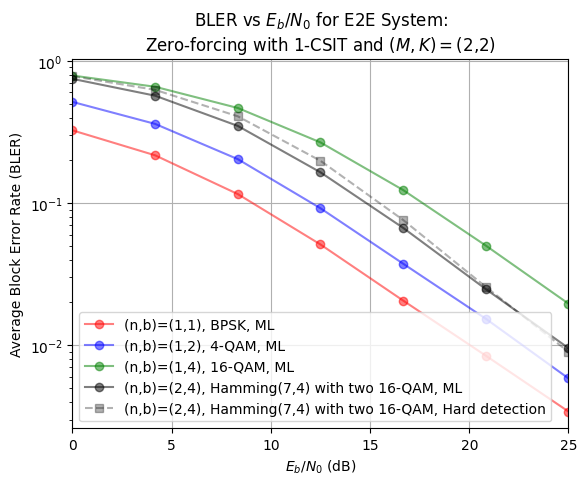

In [ ]:
# Parameters====================================================================
K = 2 # Number of users
M = 2 # Number of BS antennas
T = 1 # Number of time intervals

alph = 1 # current CSIT parameter
bet = 0 # delayed CSIT parameter
gam = 1 # CSIR parameter

fig_count = 0
for (simulation_num, modulation_mode, detection_mode) in  [(1,'BPSK','ML'),(2,'4-QAM','ML'),(3,'16-QAM','ML'),(4,'Hamming(7,4) with two 16-QAM','ML'),
 (8,'Hamming(7,4) with two 16-QAM','Hard detection')]:
 # (5,'BPSK','Hard detection'),(6,'4-QAM','Hard detection'),(7,'16-QAM','Hard detection'),

  print(f'{simulation_num}, {modulation_mode}, {detection_mode}')

  if modulation_mode == 'BPSK':
    b = 1 # number of bits per message
    n = 1 # number of channel use per modulated message
  elif modulation_mode == '4-QAM':
    b = 2 # number of bits per message
    n = 1 # number of channel use per modulated message
  elif modulation_mode == '16-QAM':
    b = 4 # number of bits per message
    n = 1 # number of channel use per modulated message
  elif modulation_mode == 'Hamming(7,4) with two 16-QAM':
    # 2 symbols of 16-QAM for Hamming(7,4) (bit_per_symbol = 4, channel_use_per_symbol = 2)
    b = 4 # number of bits per message
    n = 2 # number of channel use per modulated message

  n_t = np.ones((T,),dtype=np.int32)*n # Number of channel uses in each time interval
  b_t_k = np.ones((T,K),dtype=np.int32)*b # Number of bits in each user message in a time interval

  n_samples_eval = 50_000
  #SNR_dB_eval_num = 7
  #SNR_dB_eval = np.linspace(0,25,SNR_dB_eval_num)
  Eb_N0_dB_eval_num = 7
  Eb_N0_dB_eval = np.linspace(0,25,Eb_N0_dB_eval_num)

  BLER_list = []
  mean_BLER = np.zeros(Eb_N0_dB_eval_num,)

  for i in range(Eb_N0_dB_eval_num):
    # Messages ===
    messages_indices_list = []
    messages_binary_list = []
    for t in range(T):
      for k in range(K):
        bit_per_symbol = b_t_k[t,k]
        messages_t_k = np.random.randint(low=0, high=2**bit_per_symbol, size=n_samples_eval, dtype=np.int32)
        messages_indices_list.append(messages_t_k) # message indexing
        messages_binary_list.append(binary_encoding(messages_t_k,bit_per_symbol)) # binary representation of messages

    # --- Noise power ---
    #snr = 10**(SNR_dB_eval[i]/10)
    Eb_N0 = 10**(Eb_N0_dB_eval[i]/10)
    snr = np.empty((T,))
    noise_std = np.empty((T,))
    for t in range(T):
      if modulation_mode == 'Hamming(7,4) with two 16-QAM':
        snr[t] = Eb_N0*b*(8/7)/(n_t[t])
      else:
        snr[t] = Eb_N0*b/(n_t[t])
      noise_std[t] = sqrt(0.5/snr[t])


    # Channel ===
    channel_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = np.random.normal(loc=0.0, scale=np.sqrt(0.5), size=[n_samples_eval,K,2*M])
        channel_list.append(channel_t_n)

    # --- CSIR and CSIT ---
    # Current CSIT parameters:
    sigm = np.empty((T,))
    for t in range(T):
      alph_P = alph*snr[t]/(snr[t]+1-alph)
      sigm[t] = snr[t]**(-alph_P)

    # CSIR parameters:
    csir_sigm = np.empty((T,))
    for t in range(T):
      gam_P = gam*snr[t]/(snr[t]+1-gam)
      csir_sigm[t] = snr[t]**(-gam_P)

    csir_list = []
    current_CSIT_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = channel_list[np.sum(n_t[:t]) + n_index]

        # Current CSIT
        current_ch_error_t_n = np.random.normal(loc=0.0, scale=np.sqrt(0.5*sigm[t]), size=[n_samples_eval,K,2*M])
        current_CSIT_list.append(channel_t_n - current_ch_error_t_n)

        # CSIR
        csir_ch_error_t_n = np.random.normal(loc=0.0, scale=np.sqrt(0.5*csir_sigm[t]), size=[n_samples_eval,K,2*M])
        csir_list.append(channel_t_n - csir_ch_error_t_n)

    # --- Tx ---
    # 1. Channel Coding and Modulation
    modulated_signal_list = [] # modulated_signal_list[t * K + k] is of shape (n_samples_eval,2*n_t[t]), where 2 is for I and Q part of symbol in each channel use
    for t in range(T):
      for k in range(K):
        if modulation_mode == 'BPSK':
          modulated_signal_list.append(encoding_BPSK_lookup(messages_indices_list[t * K + k]))# shape = (n_samples_eval, 2)
        elif modulation_mode == '4-QAM':
          modulated_signal_list.append(encoding_4QAM_gray_lookup(messages_indices_list[t * K + k]))# shape = (n_samples_eval, 2)
        elif modulation_mode == '16-QAM':
          modulated_signal_list.append(encoding_16QAM_gray_lookup(messages_indices_list[t * K + k]))# shape = (n_samples_eval, 2)
        elif modulation_mode == 'Hamming(7,4) with two 16-QAM':
          # Channel Coding by Hamming(7,4)
          Hamming_codeword_matrix = hamming_encode_stream(messages_binary_list[t * K + k])
          # Modulation: 2 symbols of 16-QAM for Hamming(7,4) (bit_per_symbol = 4, channel_use_per_symbol = 2)
          modulated_signal_list.append(modulate_16qam_hamming_7_4(Hamming_codeword_matrix))# shape: (n_samples_eval,4)

    # 2. Beamforming and Power allocation
    tx_output_list = []
    W_zf_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        tx_t_n = np.zeros((n_samples_eval,2*M))
        W_zf_t_n = np.zeros((n_samples_eval,M,K)) + 1j * np.zeros((n_samples_eval,M,K))
        for sample_index in range(n_samples_eval):
          # Channel matrix at transmitter
          H_at_Tx = current_CSIT_list[np.sum(n_t[:t]) + n_index][sample_index,...] # Shape: (K , 2*M)
          H_at_Tx_complex = H_at_Tx[...,:M] + 1j * H_at_Tx[...,M:] # Shape: (K, M)

          # ZF beamforming matrix
          W_zf = zero_forcing_precoder(H_at_Tx, 1.0) # Shape: (2*M , K)
          W_zf_complex = W_zf[:M,...] + 1j * W_zf[M:,...] # Shape: (M, K)
          W_zf_t_n[sample_index,...] = W_zf_complex

          for k in range(K):
            # Real part of modulated signal of user k in the nth symbol: modulated_signal_list[t * K + k][sample_index,2*n_index]
            symbol_n_I = modulated_signal_list[t * K + k][sample_index,2*n_index]
            # Imaginary part of modulated signal of user k in the (n_index)th symbol: modulated_signal_list[t * K + k][sample_index,2*n_index + 1]
            symbol_n_Q = modulated_signal_list[t * K + k][sample_index,2*n_index+1]
            symbol_n = symbol_n_I + 1j * symbol_n_Q

            # Applying beamforming
            tx_t_n_complex = W_zf_complex[:,k]*symbol_n

            # Real part of the transmitted signal in the nth channel user of time t
            tx_t_n[sample_index,:M] += np.real(tx_t_n_complex)

            # Imaginary part of the transmitted signal in the nth channel user of time t
            tx_t_n[sample_index,M:] += np.imag(tx_t_n_complex)

        tx_output_list.append(tx_t_n)
        W_zf_list.append(W_zf_t_n)

    # --- Channel ---
    received_signal_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        received_signal_t_n = np.zeros((n_samples_eval,2*K))
        for sample_index in range(n_samples_eval):
          # Complex channel matrix
          H = channel_list[np.sum(n_t[:t]) + n_index][sample_index,...]# Shape: (K, 2*M)
          H_complex = H[...,:M] + 1j * H[...,M:] # Shape: (K,M)

          # Complex Tx signal
          x = tx_output_list[np.sum(n_t[:t]) + n_index][sample_index,:M] + 1j * tx_output_list[np.sum(n_t[:t]) + n_index][sample_index,M:] # Shape: (M,1)

          # AWGN noise
          noise = np.random.normal(loc=0.0, scale=noise_std[t], size=(K,)) + 1j * np.random.normal(loc=0.0, scale=noise_std[t], size=(K,))

          # Complex received signal
          y = H_complex @ x + noise # Shape: (K,1)
          received_signal_t_n[sample_index,:] = np.concatenate((y.real,y.imag), axis = 0).reshape(2*K,)

        received_signal_list.append(received_signal_t_n)

    # --- Decoder ---
    # 1. Combining Filter
    filtered_output_list = []
    for t in range(T):
      for k in range(K):
        filtered_output_t_k = np.zeros((n_samples_eval,2*n_t[t]))
        for n_index in range(n_t[t]):
          for sample_index in range(n_samples_eval):
            # Channel matrix at the receiver
            H_at_Rx = csir_list[np.sum(n_t[:t]) + n_index][sample_index,...] # Shape: (K , 2*M)
            H_at_Rx_complex = H_at_Rx[...,:M] + 1j * H_at_Rx[...,M:]

            # Precoding matrix calculated at the receiver assuming that the receiver knows CSIT
            W_zf_at_Rx_complex = W_zf_list[np.sum(n_t[:t]) + n_index][sample_index,...] # Shape: (M, K)

            # Received signal at user k
            y_k = received_signal_list[np.sum(n_t[:t]) + n_index][sample_index, k] + 1j * received_signal_list[np.sum(n_t[:t]) + n_index][sample_index, K + k]
            # Combining factor
            g_k = H_at_Rx_complex[k,:] @ W_zf_at_Rx_complex[:,k]
            # Adjusting the received signal
            r_k = (g_k.conj()/(np.linalg.norm(g_k)**2)) * y_k
            # Saving the updates
            filtered_output_t_k[sample_index,2*n_index:(2*(n_index + 1))] = np.array([r_k.real,r_k.imag])

        filtered_output_list.append(filtered_output_t_k)

    # 2. Detection
    messages_indices_detected_list = []
    if detection_mode == 'ML':
      for t in range(T):
        for k in range(K):
          # 1. Received signal of user k in time interval t
          received_symbols = filtered_output_list[t * K + k] # Shape: (n_samples_eval,2*n_t[t])

          # 2. Dictionary of messages indices
          data_indices_dict = np.arange(0,2**b_t_k[t,k])
          data_binary_dict = np.array(binary_encoding(data_indices_dict, b_t_k[t,k]), dtype=np.uint8)

          # 3. Soft dictionary of encoded and modulated signal
          if modulation_mode == 'BPSK':
            symbol_dict = encoding_BPSK_lookup(data_indices_dict)
          elif modulation_mode == '4-QAM':
            symbol_dict = encoding_4QAM_gray_lookup(data_indices_dict)
          elif modulation_mode == '16-QAM':
            symbol_dict = encoding_16QAM_gray_lookup(data_indices_dict)
          elif modulation_mode == 'Hamming(7,4) with two 16-QAM':
            codeword_dict = hamming_encode_stream(data_binary_dict)
            symbol_dict = modulate_16qam_hamming_7_4(codeword_dict)

          # 4. ML detection
          decoded_bits, decoded_indices = soft_ml_decoder(received_symbols, symbol_dict, data_binary_dict)
          # decoded_bits of shape: (n_samples_eval, b_t_k[t,k])
          # decoded_indices of shape: (n_samples_eval,)

          # 5. Saving detected symbols
          messages_indices_detected_list.append(decoded_indices)
    elif detection_mode == 'Hard detection':
      for t in range(T):
        for k in range(K):
          # 1. Received signal of user k in time interval t
          received_symbols = filtered_output_list[t * K + k] # Shape: (n_samples_eval,2*n_t[t])

          # 2. Demodulation with hard decision
          if modulation_mode == 'BPSK':
            decoded_bits = decoding_BPSK_hard(received_symbols)
          elif modulation_mode == '4-QAM':
            decoded_bits = decoding_4QAM_gray_hard(received_symbols)
          elif modulation_mode == '16-QAM':
            decoded_bits = decoding_16QAM_gray_hard(received_symbols)
          elif modulation_mode == 'Hamming(7,4) with two 16-QAM':
            # Demodulation:
            code1 = decoding_16QAM_gray_hard(received_symbols[:,:2]) #(c2, c4, c5, c6)
            code2 = decoding_16QAM_gray_hard(received_symbols[:,2:]) #(c0, c1, c3, _)
            codeblock = np.concatenate((code1, code2), axis = -1)
            detected_codeword = codeblock[:,[4,5,0,6,1,2,3]]
            # Channel Decoding
            decoded_bits, _, _ = hamming_decode_correct_stream(detected_codeword)

          # 4. Detecting messages indices
          messages_indices_detected_list.append(binary_decoding(decoded_bits, b_t_k[t,k]))

    # --- BLER calculation ---
    BLER = np.zeros((T, K))
    mean_BLER_count = 0
    for t in range(T):
      for k in range(K):
        BLER[t,k] = np.count_nonzero(messages_indices_list[t * K + k] !=
                                      messages_indices_detected_list[t * K + k]) / n_samples_eval
        mean_BLER[i] = mean_BLER[i] + BLER[t,k]
    #print(BLER)
    BLER_list.append(BLER)
    mean_BLER[i] = mean_BLER[i]/(T*K)

  if simulation_num == 1:
    mean_BLER1 = np.array(mean_BLER)
    label1 = '(n,b)=' + f'({n},{b}), {modulation_mode}, {detection_mode}'
  elif simulation_num == 2:
    mean_BLER2 = np.array(mean_BLER)
    label2 = '(n,b)=' + f'({n},{b}), {modulation_mode}, {detection_mode}'
  elif simulation_num == 3:
    mean_BLER3 = np.array(mean_BLER)
    label3 = '(n,b)=' + f'({n},{b}), {modulation_mode}, {detection_mode}'
  elif simulation_num == 4:
    mean_BLER4 = np.array(mean_BLER)
    label4 = '(n,b)=' + f'({n},{b}), {modulation_mode}, {detection_mode}'
  elif simulation_num == 5:
    mean_BLER5 = np.array(mean_BLER)
    label5 = '(n,b)=' + f'({n},{b}), {modulation_mode}, {detection_mode}'
  elif simulation_num == 6:
    mean_BLER6 = np.array(mean_BLER)
    label6 = '(n,b)=' + f'({n},{b}), {modulation_mode}, {detection_mode}'
  elif simulation_num == 7:
    mean_BLER7 = np.array(mean_BLER)
    label7 = '(n,b)=' + f'({n},{b}), {modulation_mode}, {detection_mode}'
  elif simulation_num == 8:
    mean_BLER8 = np.array(mean_BLER)
    label8 = '(n,b)=' + f'({n},{b}), {modulation_mode}, {detection_mode}'

# --- BLER plot ---
plt.figure(fig_count+1)
BLER_plot1, = plt.plot(Eb_N0_dB_eval, mean_BLER1, 'r-o', label = label1)
BLER_plot1.set_alpha(0.5)
BLER_plot2, = plt.plot(Eb_N0_dB_eval, mean_BLER2, 'b-o', label = label2)
BLER_plot2.set_alpha(0.5)
BLER_plot3, = plt.plot(Eb_N0_dB_eval, mean_BLER3, 'g-o', label = label3)
BLER_plot3.set_alpha(0.5)
BLER_plot4, = plt.plot(Eb_N0_dB_eval, mean_BLER4, 'k-o', label = label4)
BLER_plot4.set_alpha(0.5)
#BLER_plot5, = plt.plot(Eb_N0_dB_eval, mean_BLER5, 'r--s', label = label5)
#BLER_plot5.set_alpha(0.3)
#BLER_plot6, = plt.plot(Eb_N0_dB_eval, mean_BLER6, 'b--s', label = label6)
#BLER_plot6.set_alpha(0.3)
#BLER_plot7, = plt.plot(Eb_N0_dB_eval, mean_BLER7, 'g--s', label = label7)
#BLER_plot7.set_alpha(0.3)
BLER_plot8, = plt.plot(Eb_N0_dB_eval, mean_BLER8, 'k--s', label = label8)
BLER_plot8.set_alpha(0.3)
plt.legend(loc = 'best')
plt.xlabel(r'$E_b/N_0$' + ' (dB)')
plt.ylabel('Average Block Error Rate (BLER)')
plt.xlim([min(Eb_N0_dB_eval),max(Eb_N0_dB_eval)])
plt.yscale("log")
plt.title('BLER vs ' + r'$E_b/N_0$' + f' for E2E System:\nZero-forcing with {alph}-CSIT and ' + r'$(M,K)=$' + f'({M},{K})')
plt.grid()
plt.savefig(f'BLER_Zf_{alph}.png')

# 8. E2E: TDMA

1, BPSK, ML
2, 4-QAM, ML
3, 16-QAM, ML
4, Hamming(7,4) with two 16-QAM, ML
8, Hamming(7,4) with two 16-QAM, Hard detection


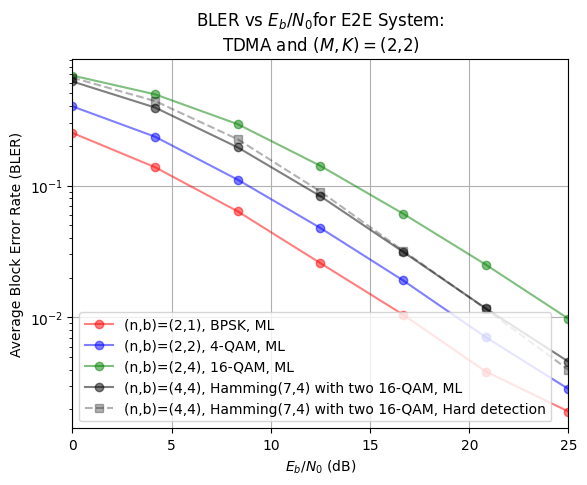

In [ ]:
# Parameters====================================================================
K = 2 # Number of users
M = 2 # Number of BS antennas
T = 1 # Number of time intervals

alph = 0 # current CSIT parameter
bet = 0 # delayed CSIT parameter
gam = 1 # CSIR parameter

fig_count = 0
for (simulation_num, modulation_mode, detection_mode) in  [(1,'BPSK','ML'),(2,'4-QAM','ML'),(3,'16-QAM','ML'),(4,'Hamming(7,4) with two 16-QAM','ML'),
 (8,'Hamming(7,4) with two 16-QAM','Hard detection')]:
 # (5,'BPSK','Hard detection'),(6,'4-QAM','Hard detection'),(7,'16-QAM','Hard detection'),

  print(f'{simulation_num}, {modulation_mode}, {detection_mode}')

  if modulation_mode == 'BPSK':
    b = 1 # number of bits per message
    n = 1 # number of channel use per modulated message
  elif modulation_mode == '4-QAM':
    b = 2 # number of bits per message
    n = 1 # number of channel use per modulated message
  elif modulation_mode == '16-QAM':
    b = 4 # number of bits per message
    n = 1 # number of channel use per modulated message
  elif modulation_mode == 'Hamming(7,4) with two 16-QAM':
    # 2 symbols of 16-QAM for Hamming(7,4) (bit_per_symbol = 4, channel_use_per_symbol = 2)
    b = 4 # number of bits per message
    n = 2 # number of channel use per modulated message

  n_t = np.ones((T,),dtype=np.int32)*n*K # Number of channel uses in each time interval, where K is the number of time-division slots
  b_t_k = np.ones((T,K),dtype=np.int32)*b # Number of bits in each user message in a time interval

  n_samples_eval = 50_000
  #SNR_dB_eval_num = 7
  #SNR_dB_eval = np.linspace(0,25,SNR_dB_eval_num)
  Eb_N0_dB_eval_num = 7
  Eb_N0_dB_eval = np.linspace(0,25,Eb_N0_dB_eval_num)

  BLER_list = []
  mean_BLER = np.zeros(Eb_N0_dB_eval_num,)

  for i in range(Eb_N0_dB_eval_num):

    # Messages ===
    messages_indices_list = []
    messages_binary_list = []
    for t in range(T):
      for k in range(K):
        bit_per_symbol = b_t_k[t,k]
        messages_t_k = np.random.randint(low=0, high=2**bit_per_symbol, size=n_samples_eval, dtype=np.int32)
        messages_indices_list.append(messages_t_k) # message indexing
        messages_binary_list.append(binary_encoding(messages_t_k,bit_per_symbol)) # binary representation of messages

    # --- Noise power ---
    #snr = 10**(SNR_dB_eval[i]/10)
    Eb_N0 = 10**(Eb_N0_dB_eval[i]/10)
    snr = np.empty((T,))
    noise_std = np.empty((T,))
    for t in range(T):
      if modulation_mode == 'Hamming(7,4) with two 16-QAM':
        snr[t] = Eb_N0*b*(8/7)/(n_t[t]/K)
      else:
        snr[t] = Eb_N0*b/(n_t[t]/K)
      noise_std[t] = sqrt(0.5/snr[t])

    # Channel ===
    channel_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = np.random.normal(loc=0.0, scale=np.sqrt(0.5), size=[n_samples_eval,K,2*M])
        channel_list.append(channel_t_n)

    # --- CSIR ---
    # CSIR parameters:
    csir_sigm = np.empty((T,))
    for t in range(T):
      gam_P = gam*snr[t]/(snr[t]+1-gam)
      csir_sigm[t] = snr[t]**(-gam_P)

    csir_list = []
    current_CSIT_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = channel_list[np.sum(n_t[:t]) + n_index]

        # CSIR
        csir_ch_error_t_n = np.random.normal(loc=0.0, scale=np.sqrt(0.5*csir_sigm[t]), size=[n_samples_eval,K,2*M])
        csir_list.append(channel_t_n - csir_ch_error_t_n)

    # --- Tx ---
    # 1. Channel Coding and Modulation
    modulated_signal_list = []
    # modulated_signal_list[t * K + k] is of shape (n_samples_eval,2*n_t[t]//K), where 2 is for I and Q part of symbol in each channel use and K stads for the number of time-division slots
    for t in range(T):
      for k in range(K):
        if modulation_mode == 'BPSK':
          modulated_signal_list.append(encoding_BPSK_lookup(messages_indices_list[t * K + k]))# shape = (n_samples_eval, 2)
        elif modulation_mode == '4-QAM':
          modulated_signal_list.append(encoding_4QAM_gray_lookup(messages_indices_list[t * K + k]))# shape = (n_samples_eval, 2)
        elif modulation_mode == '16-QAM':
          modulated_signal_list.append(encoding_16QAM_gray_lookup(messages_indices_list[t * K + k]))# shape = (n_samples_eval, 2)
        elif modulation_mode == 'Hamming(7,4) with two 16-QAM':
          # Channel Coding by Hamming(7,4)
          Hamming_codeword_matrix = hamming_encode_stream(messages_binary_list[t * K + k])
          # Modulation: 2 symbols of 16-QAM for Hamming(7,4) (bit_per_symbol = 4, channel_use_per_symbol = 2)
          modulated_signal_list.append(modulate_16qam_hamming_7_4(Hamming_codeword_matrix))# shape: (n_samples_eval,4)

    # 2. Beamforming and Power allocation
    tx_output_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        tx_t_n = np.zeros((n_samples_eval,2*M))

        k = n_index//(n_t[t]//K)
        n_index_k = n_index % (n_t[t]//K)

        for sample_index in range(n_samples_eval):

          # Equal power beamforming for user k
          w_k_complex = np.ones((M,), dtype = np.float32)/np.sqrt(M) + 1j * np.zeros((M,), dtype = np.float32)

          # Real part of modulated signal of user k in the nth symbol: modulated_signal_list[t * K + k][sample_index,2*n_index_k]
          symbol_n_I = modulated_signal_list[t * K + k][sample_index,2*n_index_k]
          # Imaginary part of modulated signal of user k in the (n_index)th symbol: modulated_signal_list[t * K + k][sample_index,2*n_index_k + 1]
          symbol_n_Q = modulated_signal_list[t * K + k][sample_index,2*n_index_k + 1]
          symbol_n = symbol_n_I + 1j * symbol_n_Q

          # Applying beamforming
          tx_t_n_complex = w_k_complex*symbol_n

          # Real part of the transmitted signal in the nth channel user of time t
          tx_t_n[sample_index,:M] = np.real(tx_t_n_complex)

          # Imaginary part of the transmitted signal in the nth channel user of time t
          tx_t_n[sample_index,M:] = np.imag(tx_t_n_complex)

        tx_output_list.append(tx_t_n)

    # --- Channel ---
    received_signal_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        received_signal_t_n = np.zeros((n_samples_eval,2*K))
        for sample_index in range(n_samples_eval):
          # Complex channel matrix
          H = channel_list[np.sum(n_t[:t]) + n_index][sample_index,...]# Shape: (K, 2*M)
          H_complex = H[...,:M] + 1j * H[...,M:] # Shape: (K,M)

          # Complex Tx signal
          x = tx_output_list[np.sum(n_t[:t]) + n_index][sample_index,:M] + 1j * tx_output_list[np.sum(n_t[:t]) + n_index][sample_index,M:] # Shape: (M,1)

          # AWGN noise
          noise = np.random.normal(loc=0.0, scale=noise_std[t], size=(K,)) + 1j * np.random.normal(loc=0.0, scale=noise_std[t], size=(K,))

          # Complex received signal
          y = H_complex @ x + noise # Shape: (K,1)
          received_signal_t_n[sample_index,:] = np.concatenate((y.real,y.imag), axis = 0).reshape(2*K,)

        received_signal_list.append(received_signal_t_n)

    # --- Decoder ---
    # 1. Combining Filter
    filtered_output_list = []
    for t in range(T):
      for k in range(K):
        filtered_output_t_k = np.zeros((n_samples_eval,2*n_t[t]//K))

        for n_index in range(n_t[t]):
          k_index = n_index//(n_t[t]//K)
          n_index_k = n_index % (n_t[t]//K)

          if k_index == k:
            for sample_index in range(n_samples_eval):
              # Channel matrix at the receiver
              H_at_Rx = csir_list[np.sum(n_t[:t]) + n_index][sample_index,...] # Shape: (K , 2*M)
              H_at_Rx_complex = H_at_Rx[...,:M] + 1j * H_at_Rx[...,M:]

              # Equal power beamforming for user k
              w_k_complex = np.ones((M,), dtype = np.float32)/np.sqrt(M) + 1j * np.zeros((M,), dtype = np.float32)

              # Received signal at user k
              y_k = received_signal_list[np.sum(n_t[:t]) + n_index][sample_index, k] + 1j * received_signal_list[np.sum(n_t[:t]) + n_index][sample_index, K + k]
              # Combining factor
              g_k = H_at_Rx_complex[k,:] @ w_k_complex
              # Adjusting the received signal
              r_k = (g_k.conj()/(np.linalg.norm(g_k)**2)) * y_k
              # Saving the updates
              filtered_output_t_k[sample_index,2*n_index_k:(2*(n_index_k + 1))] = np.array([r_k.real,r_k.imag])

        filtered_output_list.append(filtered_output_t_k)

    # 2. Detection
    messages_indices_detected_list = []
    if detection_mode == 'ML':
      for t in range(T):
          for k in range(K):
            # 1. Received signal of user k in time interval t
            received_symbols = filtered_output_list[t * K + k] # Shape: (n_samples_eval,2*n_t[t]//K)

            # 2. Dictionary of messages indices
            data_indices_dict = np.arange(0,2**b_t_k[t,k])
            data_binary_dict = np.array(binary_encoding(data_indices_dict, b_t_k[t,k]), dtype=np.uint8)

            # 3. Soft dictionary of encoded and modulated signal
            if modulation_mode == 'BPSK':
              symbol_dict = encoding_BPSK_lookup(data_indices_dict)
            elif modulation_mode == '4-QAM':
              symbol_dict = encoding_4QAM_gray_lookup(data_indices_dict)
            elif modulation_mode == '16-QAM':
              symbol_dict = encoding_16QAM_gray_lookup(data_indices_dict)
            elif modulation_mode == 'Hamming(7,4) with two 16-QAM':
              codeword_dict = hamming_encode_stream(data_binary_dict)
              symbol_dict = modulate_16qam_hamming_7_4(codeword_dict)

            # 4. ML detection
            decoded_bits, decoded_indices = soft_ml_decoder(received_symbols, symbol_dict, data_binary_dict)
            # decoded_bits of shape: (n_samples_eval, b_t_k[t,k])
            # decoded_indices of shape: (n_samples_eval,)

            # 5. Saving detected symbols
            messages_indices_detected_list.append(decoded_indices)
    elif detection_mode == 'Hard detection':
      for t in range(T):
        for k in range(K):
          # 1. Received signal of user k in time interval t
          received_symbols = filtered_output_list[t * K + k] # Shape: (n_samples_eval,2*n_t[t]//K)

          # 2. Demodulation with hard decision
          if modulation_mode == 'BPSK':
            decoded_bits = decoding_BPSK_hard(received_symbols)
          elif modulation_mode == '4-QAM':
            decoded_bits = decoding_4QAM_gray_hard(received_symbols)
          elif modulation_mode == '16-QAM':
            decoded_bits = decoding_16QAM_gray_hard(received_symbols)
          elif modulation_mode == 'Hamming(7,4) with two 16-QAM':
            # Demodulation:
            code1 = decoding_16QAM_gray_hard(received_symbols[:,:2]) #(c2, c4, c5, c6)
            code2 = decoding_16QAM_gray_hard(received_symbols[:,2:]) #(c0, c1, c3, _)
            codeblock = np.concatenate((code1, code2), axis = -1)
            detected_codeword = codeblock[:,[4,5,0,6,1,2,3]]
            # Channel Decoding
            decoded_bits, _, _ = hamming_decode_correct_stream(detected_codeword)

          # 4. Detecting messages indices
          messages_indices_detected_list.append(binary_decoding(decoded_bits, b_t_k[t,k]))

    # --- BLER calculation ---
    BLER = np.zeros((T, K))
    mean_BLER_count = 0
    for t in range(T):
      for k in range(K):
        BLER[t,k] = np.count_nonzero(messages_indices_list[t * K + k] !=
                                      messages_indices_detected_list[t * K + k]) / n_samples_eval
        mean_BLER[i] = mean_BLER[i] + BLER[t,k]
    #print(BLER)
    BLER_list.append(BLER)
    mean_BLER[i] = mean_BLER[i]/(T*K)

  if simulation_num == 1:
    mean_BLER1 = np.array(mean_BLER)
    label1 = r'$(n,b)=$' + f'({K*n},{b}), {modulation_mode}, {detection_mode}'
  elif simulation_num == 2:
    mean_BLER2 = np.array(mean_BLER)
    label2 = r'$(n,b)=$' + f'({K*n},{b}), {modulation_mode}, {detection_mode}'
  elif simulation_num == 3:
    mean_BLER3 = np.array(mean_BLER)
    label3 = r'$(n,b)=$' + f'({K*n},{b}), {modulation_mode}, {detection_mode}'
  elif simulation_num == 4:
    mean_BLER4 = np.array(mean_BLER)
    label4 = r'$(n,b)=$' + f'({K*n},{b}), {modulation_mode}, {detection_mode}'
  elif simulation_num == 5:
    mean_BLER5 = np.array(mean_BLER)
    label5 = r'$(n,b)=$' + f'({K*n},{b}), {modulation_mode}, {detection_mode}'
  elif simulation_num == 6:
    mean_BLER6 = np.array(mean_BLER)
    label6 = r'$(n,b)=$' + f'({K*n},{b}), {modulation_mode}, {detection_mode}'
  elif simulation_num == 7:
    mean_BLER7 = np.array(mean_BLER)
    label7 = r'$(n,b)=$' + f'({K*n},{b}), {modulation_mode}, {detection_mode}'
  elif simulation_num == 8:
    mean_BLER8 = np.array(mean_BLER)
    label8 = r'$(n,b)=$' + f'({K*n},{b}), {modulation_mode}, {detection_mode}'

# --- BLER plot ---
plt.figure(fig_count+1,figsize=(7, 6))
BLER_plot1, = plt.plot(Eb_N0_dB_eval, mean_BLER1, 'r-o', label = label1)
BLER_plot1.set_alpha(0.5)
BLER_plot2, = plt.plot(Eb_N0_dB_eval, mean_BLER2, 'b-o', label = label2)
BLER_plot2.set_alpha(0.5)
BLER_plot3, = plt.plot(Eb_N0_dB_eval, mean_BLER3, 'g-o', label = label3)
BLER_plot3.set_alpha(0.5)
BLER_plot4, = plt.plot(Eb_N0_dB_eval, mean_BLER4, 'k-o', label = label4)
BLER_plot4.set_alpha(0.5)
#BLER_plot5, = plt.plot(Eb_N0_dB_eval, mean_BLER5, 'r--s', label = label5)
#BLER_plot5.set_alpha(0.3)
#BLER_plot6, = plt.plot(Eb_N0_dB_eval, mean_BLER6, 'b--s', label = label6)
#BLER_plot6.set_alpha(0.3)
#BLER_plot7, = plt.plot(Eb_N0_dB_eval, mean_BLER7, 'g--s', label = label7)
#BLER_plot7.set_alpha(0.3)
BLER_plot8, = plt.plot(Eb_N0_dB_eval, mean_BLER8, 'k--s', label = label8)
BLER_plot8.set_alpha(0.3)
plt.legend(loc = 'best')
plt.xlabel(r'$E_b/N_0$' + ' (dB)')
plt.ylabel('Average Block Error Rate (BLER)')
plt.xlim([min(Eb_N0_dB_eval),max(Eb_N0_dB_eval)])
plt.yscale("log")
plt.title('BLER vs ' + r'$E_b/N_0$' + 'for E2E System:\nTDMA and ' + r'$(M,K)=$' + f'({M},{K})')
plt.grid()
plt.savefig(f"BLER_TDMA.png")

# 9. E2E: MAT

1, BPSK, ML
2, 4-QAM, ML
3, 16-QAM, ML
4, Hamming(7,4) with two 16-QAM, ML
8, Hamming(7,4) with two 16-QAM, Hard detection


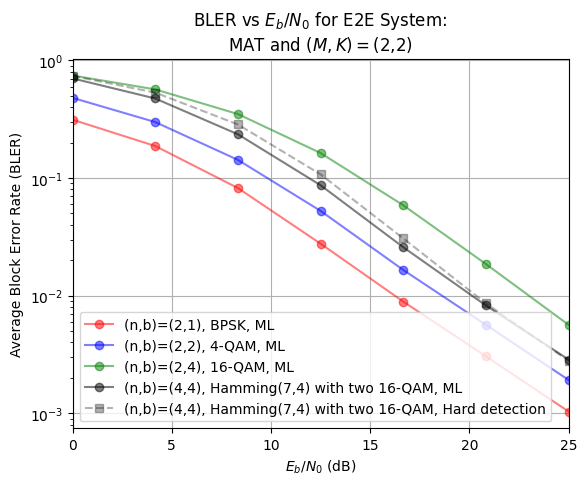

In [ ]:
# Parameters====================================================================
K = 2 # Number of users
M = 2 # Number of BS antennas
T = 2 # Number of time intervals

alph = 0 # current CSIT parameter
bet = 1 # delayed CSIT parameter
gam = 1 # CSIR parameter

fig_count = 2
for (simulation_num, modulation_mode, detection_mode) in  [(1,'BPSK','ML'),(2,'4-QAM','ML'),(3,'16-QAM','ML'),(4,'Hamming(7,4) with two 16-QAM','ML'),
 (8,'Hamming(7,4) with two 16-QAM','Hard detection')]:
 # (5,'BPSK','Hard detection'),(6,'4-QAM','Hard detection'),(7,'16-QAM','Hard detection'),

  print(f'{simulation_num}, {modulation_mode}, {detection_mode}')

  if modulation_mode == 'BPSK':
    b = 1 # number of bits per message
    n = 1 # number of channel use per modulated message
  elif modulation_mode == '4-QAM':
    b = 2 # number of bits per message
    n = 1 # number of channel use per modulated message
  elif modulation_mode == '16-QAM':
    b = 4 # number of bits per message
    n = 1 # number of channel use per modulated message
  elif modulation_mode == 'Hamming(7,4) with two 16-QAM':
    # 2 symbols of 16-QAM for Hamming(7,4) (bit_per_symbol = 4, channel_use_per_symbol = 2)
    b = 4 # number of bits per message
    n = 2 # number of channel use per modulated message

  n_t = np.ones((T,),dtype=np.int32) # Number of channel uses in each time interval, where K is the number of time-division slots
  n_t[0] = n*K
  n_t[1] = n
  b_t_k = np.ones((T,K),dtype=np.int32) # Number of bits in each user message in a time interval
  b_t_k[0,:] = b
  b_t_k[1,:] = 0

  n_samples_eval = 100_000
  #SNR_dB_eval_num = 7
  #SNR_dB_eval = np.linspace(0,25,SNR_dB_eval_num)
  Eb_N0_dB_eval_num = 7
  Eb_N0_dB_eval = np.linspace(0,25,Eb_N0_dB_eval_num)

  BLER_list = []
  mean_BLER = np.zeros(Eb_N0_dB_eval_num,)

  for i in range(Eb_N0_dB_eval_num):

    # Messages ===
    messages_indices_list = []
    messages_binary_list = []
    for t in range(T):
      if t == 0:
        for k in range(K):
          bit_per_symbol = b_t_k[t,k]
          messages_t_k = np.random.randint(low=0, high=2**bit_per_symbol, size=n_samples_eval, dtype=np.int32)
          messages_indices_list.append(messages_t_k) # message indexing
          messages_binary_list.append(binary_encoding(messages_t_k,bit_per_symbol)) # binary representation of messages

    # --- Noise power ---
    Eb_N0 = 10**(Eb_N0_dB_eval[i]/10)
    snr = np.empty((T,))
    noise_std = np.empty((T,))

    # Calculate the Symbol SNR for a single symbol transmission (t=0)
    if modulation_mode == 'Hamming(7,4) with two 16-QAM':
      # R_system = (b * (8/7)) / (n_t[0]/K) = (4 * 8/7) / 2 = 16/7
      snr_symbol = Eb_N0*b*(8/7)/(n_t[0]/K)
    else:
      # For BPSK, QPSK, 16QAM, R_system = b / (n_t[0]/K)
      snr_symbol = Eb_N0*b/(n_t[0]/K)

    # Apply this Symbol SNR to both time intervals
    snr[0] = snr_symbol
    snr[1] = snr_symbol

    # Calculate noise standard deviation
    for t in range(T):
      noise_std[t] = np.sqrt(0.5/snr[t])

    # Channel ===
    channel_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = np.random.normal(loc=0.0, scale=np.sqrt(0.5), size=[n_samples_eval,K,2*M])
        channel_list.append(channel_t_n)

    # --- CSIT and CSIR ---
    # Delayed CSIT parameters:
    sigma_FB = np.empty((T,))
    for t in range(T):
      bet_P = bet*snr[t]/(snr[t]+1-bet)
      sigma_FB[t] = snr[t]**(-bet_P)

    # CSIR parameters:
    csir_sigm = np.empty((T,))
    for t in range(T):
      gam_P = gam*snr[t]/(snr[t]+1-gam)
      csir_sigm[t] = snr[t]**(-gam_P)


    delayed_CSIT_list = []
    csir_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = channel_list[np.sum(n_t[:t]) + n_index]

        # Delayed CSIT
        if t < T-1:
          delayed_ch_error_t_n = np.random.normal(loc=0.0, scale=np.sqrt(0.5*sigma_FB[t]), size=[n_samples_eval,K,2*M])
          delayed_CSIT_list.append(channel_t_n - delayed_ch_error_t_n)

        # CSIR
        csir_ch_error_t_n = np.random.normal(loc=0.0, scale=np.sqrt(0.5*csir_sigm[t]), size=[n_samples_eval,K,2*M])
        csir_list.append(channel_t_n - csir_ch_error_t_n)

    # --- Tx ---
    # 1. Channel Coding and Modulation
    modulated_signal_list = []
    # modulated_signal_list[t * K + k] is of shape (n_samples_eval,2*n_t[t]//K), where 2 is for I and Q part of symbol in each channel use and K stads for the number of time-division slots
    for t in range(T):
      if t == 0:
        for k in range(K):
          if modulation_mode == 'BPSK':
            modulated_signal_list.append(encoding_BPSK_lookup(messages_indices_list[t * K + k]))# shape = (n_samples_eval, 2)
          elif modulation_mode == '4-QAM':
            modulated_signal_list.append(encoding_4QAM_gray_lookup(messages_indices_list[t * K + k]))# shape = (n_samples_eval, 2)
          elif modulation_mode == '16-QAM':
            modulated_signal_list.append(encoding_16QAM_gray_lookup(messages_indices_list[t * K + k]))# shape = (n_samples_eval, 2)
          elif modulation_mode == 'Hamming(7,4) with two 16-QAM':
            # Channel Coding by Hamming(7,4)
            Hamming_codeword_matrix = hamming_encode_stream(messages_binary_list[t * K + k])
            # Modulation: 2 symbols of 16-QAM for Hamming(7,4) (bit_per_symbol = 4, channel_use_per_symbol = 2)
            modulated_signal_list.append(modulate_16qam_hamming_7_4(Hamming_codeword_matrix))# shape: (n_samples_eval,4)

    # 2. Beamforming and Power allocation
    tx_output_list = []
    for t in range(T):
      if t == 0:
        for n_index in range(n_t[t]):
          tx_t_n = np.zeros((n_samples_eval,2*M))

          k = n_index//(n_t[t]//K)
          n_index_k = n_index % (n_t[t]//K)

          for sample_index in range(n_samples_eval):

            # Equal power beamforming for user k
            w_k_complex = np.ones((M,), dtype = np.float32)/np.sqrt(M) + 1j * np.zeros((M,), dtype = np.float32)

            # Real part of modulated signal of user k in the nth symbol: modulated_signal_list[t * K + k][sample_index,2*n_index_k]
            symbol_n_I = modulated_signal_list[t * K + k][sample_index,2*n_index_k]
            # Imaginary part of modulated signal of user k in the (n_index)th symbol: modulated_signal_list[t * K + k][sample_index,2*n_index_k + 1]
            symbol_n_Q = modulated_signal_list[t * K + k][sample_index,2*n_index_k + 1]
            symbol_n = symbol_n_I + 1j * symbol_n_Q

            # Applying beamforming
            tx_t_n_complex = w_k_complex*symbol_n

            # Real part of the transmitted signal in the nth channel user of time t
            tx_t_n[sample_index,:M] = np.real(tx_t_n_complex)

            # Imaginary part of the transmitted signal in the nth channel user of time t
            tx_t_n[sample_index,M:] = np.imag(tx_t_n_complex)

          tx_output_list.append(tx_t_n)
      elif t == 1:
        for n_index in range(n_t[t]):
          # n_t[1] = n_t[0] // K
          tx_t_n = np.zeros((n_samples_eval,2*M))

          for sample_index in range(n_samples_eval):
            overheard_interference = 0

            for k_listen in range(K):
              k_interfere = K-1 - k_listen

              # Signal of user k_interfere in time t = 0
              x_interfere = tx_output_list[k_interfere*(n_t[0]//K) + n_index][sample_index,:M] + 1j * tx_output_list[k_interfere*(n_t[0]//K) + n_index][sample_index, M:]
              # The channel vector to hear the interference of user k_interfere in time t = 0
              h_hearing_delayed = delayed_CSIT_list[k_interfere*(n_t[0]//K) + n_index][sample_index,k_listen,:M] + 1j * delayed_CSIT_list[k_interfere*(n_t[0]//K) + n_index][sample_index,k_listen,M:]
              # Beamforming in time t = 0
              w_complex = np.ones((M,), dtype = np.float32)/np.sqrt(M) + 1j * np.zeros((M,), dtype = np.float32)

              # Overheard interference
              normalization_factor = np.linalg.norm(h_hearing_delayed @ w_complex)
              overheard_interference += (h_hearing_delayed @ x_interfere)/normalization_factor

            tx_t_n_complex = overheard_interference/np.sqrt(K)
            tx_t_n[sample_index,0] = np.real(tx_t_n_complex)
            tx_t_n[sample_index,M] = np.imag(tx_t_n_complex)

          tx_output_list.append(tx_t_n)

    # --- Channel ---
    received_signal_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        received_signal_t_n = np.zeros((n_samples_eval,2*K))
        for sample_index in range(n_samples_eval):
          # Complex channel matrix
          H = channel_list[np.sum(n_t[:t]) + n_index][sample_index,...]# Shape: (K, 2*M)
          H_complex = H[...,:M] + 1j * H[...,M:] # Shape: (K,M)

          # Complex Tx signal
          x = tx_output_list[np.sum(n_t[:t]) + n_index][sample_index,:M] + 1j * tx_output_list[np.sum(n_t[:t]) + n_index][sample_index,M:] # Shape: (M,1)

          # AWGN noise
          noise = np.random.normal(loc=0.0, scale=noise_std[t], size=(K,)) + 1j * np.random.normal(loc=0.0, scale=noise_std[t], size=(K,))

          # Complex received signal
          y = H_complex @ x + noise # Shape: (K,1)
          received_signal_t_n[sample_index,:] = np.concatenate((y.real,y.imag), axis = 0).reshape(2*K,)

        received_signal_list.append(received_signal_t_n)

    # --- Decoder ---
    filtered_output_list = []
    # MAT scheme ----
    for k_listen in range(K):
      k_interfere = K -1 - k_listen

      filtered_output_t_k = np.zeros((n_samples_eval,2*n_t[0]//K))

      for n_index in range(n_t[0]//K):

        for sample_index in range(n_samples_eval):

          # 0. Beafmorming vectors for both users:
          w_complex = np.ones((M,), dtype = np.float32)/np.sqrt(M) + 1j * np.zeros((M,), dtype = np.float32)

          # 1. Received signals ---
          # Received signal at user k_listen at time t = 0
          y_k_t0 = received_signal_list[k_listen*(n_t[0]//K) + n_index][sample_index, k_listen] + 1j * received_signal_list[k_listen*(n_t[0]//K) + n_index][sample_index, K + k_listen]

          # Received interference of user k_interfere at user k_listen at time t = 0
          y_kbar_t0_at_k = received_signal_list[k_interfere*(n_t[0]//K) + n_index][sample_index, k_listen] + 1j * received_signal_list[k_interfere*(n_t[0]//K) + n_index][sample_index, K + k_listen]

          # Received signal at user k_listen at time t = 1
          y_k_t1 = received_signal_list[n_t[0] + n_index][sample_index, k_listen] + 1j * received_signal_list[n_t[0] + n_index][sample_index, K + k_listen]

          # 2. Combining factor for desired signal at time t = 0 ---
          # Channel vector of user k_listen at time t = 0
          h_k_t0 = csir_list[k_listen*(n_t[0]//K) + n_index][sample_index, k_listen, :M] + 1j * csir_list[k_listen*(n_t[0]//K) + n_index][sample_index, k_listen, M:]

          g_k_t0 = h_k_t0 @ w_complex

          # 3. Extracting the useful signal from the common signal at time t  = 1 ---

          # Channel vector of user k_interfere at time t = 0 hearing the interference of user k_listen
          h_k_t0_at_kbar = csir_list[k_listen*(n_t[0]//K) + n_index][sample_index, k_interfere, :M] + 1j * csir_list[k_listen*(n_t[0]//K) + n_index][sample_index, k_interfere, M:]

          # Channel vector of user k_listen at time t = 0 hearing the interference of user k_interfere
          h_kbar_t0_at_k = csir_list[k_interfere*(n_t[0]//K) + n_index][sample_index, k_listen, :M] + 1j * csir_list[k_interfere*(n_t[0]//K) + n_index][sample_index, k_listen, M:]

          # First channel element of user k_listen at time t = 1
          h_k_t1_e0 = csir_list[n_t[0] + n_index][sample_index, k_listen, 0] + 1j * csir_list[n_t[0] + n_index][sample_index, k_listen, M]

          normalization_factor0 = np.linalg.norm(h_k_t0_at_kbar @ w_complex)
          normalization_factor1 = np.linalg.norm(h_kbar_t0_at_k @ w_complex)

          g_k_t1 = h_k_t1_e0 * (h_k_t0_at_kbar @ w_complex) / normalization_factor0

          # 4. Useful signal from both time intervals ---
          r_k = np.array([g_k_t0, g_k_t1]).conj() @ np.array([y_k_t0, np.sqrt(K) * y_k_t1 - h_k_t1_e0 * y_kbar_t0_at_k/ normalization_factor1]) / (np.linalg.norm(np.array([g_k_t0, g_k_t1]))**2)

          #r_k = (g_k_t0.conj()/(np.linalg.norm(g_k_t0)**2)) * y_k_t0 # TDMA only

          filtered_output_t_k[sample_index,2*n_index:(2*(n_index + 1))] = np.array([r_k.real,r_k.imag])

      filtered_output_list.append(filtered_output_t_k)

    # 2. Detection
    messages_indices_detected_list = []
    t = 0
    if detection_mode == 'ML':
      for k in range(K):
        # 1. Received signal of user k in time interval t
        received_symbols = filtered_output_list[t * K + k] # Shape: (n_samples_eval,2*n_t[0]//K)

        # 2. Dictionary of messages indices
        data_indices_dict = np.arange(0,2**b_t_k[t,k])
        data_binary_dict = np.array(binary_encoding(data_indices_dict, b_t_k[t,k]), dtype=np.uint8)

        # 3. Soft dictionary of encoded and modulated signal
        if modulation_mode == 'BPSK':
          symbol_dict = encoding_BPSK_lookup(data_indices_dict)
        elif modulation_mode == '4-QAM':
          symbol_dict = encoding_4QAM_gray_lookup(data_indices_dict)
        elif modulation_mode == '16-QAM':
          symbol_dict = encoding_16QAM_gray_lookup(data_indices_dict)
        elif modulation_mode == 'Hamming(7,4) with two 16-QAM':
          codeword_dict = hamming_encode_stream(data_binary_dict)
          symbol_dict = modulate_16qam_hamming_7_4(codeword_dict)

        # 4. ML detection
        decoded_bits, decoded_indices = soft_ml_decoder(received_symbols, symbol_dict, data_binary_dict)
        # decoded_bits of shape: (n_samples_eval, b_t_k[t,k])
        # decoded_indices of shape: (n_samples_eval,)

        # 5. Saving detected symbols
        messages_indices_detected_list.append(decoded_indices)

    elif detection_mode == 'Hard detection':
      for k in range(K):
        # 1. Received signal of user k in time interval t
        received_symbols = filtered_output_list[t * K + k] # Shape: (n_samples_eval,2*n_t[0]//K)

        # 2. Demodulation with hard decision
        if modulation_mode == 'BPSK':
          decoded_bits = decoding_BPSK_hard(received_symbols)
        elif modulation_mode == '4-QAM':
          decoded_bits = decoding_4QAM_gray_hard(received_symbols)
        elif modulation_mode == '16-QAM':
          decoded_bits = decoding_16QAM_gray_hard(received_symbols)
        elif modulation_mode == 'Hamming(7,4) with two 16-QAM':
          # Demodulation:
          code1 = decoding_16QAM_gray_hard(received_symbols[:,:2]) #(c2, c4, c5, c6)
          code2 = decoding_16QAM_gray_hard(received_symbols[:,2:]) #(c0, c1, c3, _)
          codeblock = np.concatenate((code1, code2), axis = -1)
          detected_codeword = codeblock[:,[4,5,0,6,1,2,3]]
          # Channel Decoding
          decoded_bits, _, _ = hamming_decode_correct_stream(detected_codeword)

        # 4. Detecting messages indices
        messages_indices_detected_list.append(binary_decoding(decoded_bits, b_t_k[t,k]))

    # --- BLER calculation ---
    BLER = np.zeros((K,))
    mean_BLER_count = 0
    t = 0
    for k in range(K):
      BLER[k] = np.count_nonzero(messages_indices_list[t * K + k] !=
                                    messages_indices_detected_list[t * K + k]) / n_samples_eval
      mean_BLER[i] = mean_BLER[i] + BLER[k]
    #print(BLER)
    BLER_list.append(BLER)
    mean_BLER[i] = mean_BLER[i]/(K)

  if simulation_num == 1:
    mean_BLER1 = np.array(mean_BLER)
    label1 = '(n,b)=' + f'({K*n},{b}), {modulation_mode}, {detection_mode}'
  elif simulation_num == 2:
    mean_BLER2 = np.array(mean_BLER)
    label2 = '(n,b)=' + f'({K*n},{b}), {modulation_mode}, {detection_mode}'
  elif simulation_num == 3:
    mean_BLER3 = np.array(mean_BLER)
    label3 = '(n,b)=' + f'({K*n},{b}), {modulation_mode}, {detection_mode}'
  elif simulation_num == 4:
    mean_BLER4 = np.array(mean_BLER)
    label4 = '(n,b)=' + f'({K*n},{b}), {modulation_mode}, {detection_mode}'
  elif simulation_num == 5:
    mean_BLER5 = np.array(mean_BLER)
    label5 = '(n,b)=' + f'({(K+1)*n},{b}), {modulation_mode}, {detection_mode}'
  elif simulation_num == 6:
    mean_BLER6 = np.array(mean_BLER)
    label6 = '(n,b)=' + f'({(K+1)*n},{b}), {modulation_mode}, {detection_mode}'
  elif simulation_num == 7:
    mean_BLER7 = np.array(mean_BLER)
    label7 = '(n,b)=' + f'({(K+1)*n},{b}), {modulation_mode}, {detection_mode}'
  elif simulation_num == 8:
    mean_BLER8 = np.array(mean_BLER)
    label8 = '(n,b)=' + f'({(K+1)*n},{b}), {modulation_mode}, {detection_mode}'

# --- BLER plot ---
plt.figure(fig_count+1)
BLER_plot1, = plt.plot(Eb_N0_dB_eval, mean_BLER1, 'r-o', label = label1)
BLER_plot1.set_alpha(0.5)
BLER_plot2, = plt.plot(Eb_N0_dB_eval, mean_BLER2, 'b-o', label = label2)
BLER_plot2.set_alpha(0.5)
BLER_plot3, = plt.plot(Eb_N0_dB_eval, mean_BLER3, 'g-o', label = label3)
BLER_plot3.set_alpha(0.5)
BLER_plot4, = plt.plot(Eb_N0_dB_eval, mean_BLER4, 'k-o', label = label4)
BLER_plot4.set_alpha(0.5)
#BLER_plot5, = plt.plot(Eb_N0_dB_eval, mean_BLER5, 'r--s', label = label5)
#BLER_plot5.set_alpha(0.3)
#BLER_plot6, = plt.plot(Eb_N0_dB_eval, mean_BLER6, 'b--s', label = label6)
#BLER_plot6.set_alpha(0.3)
#BLER_plot7, = plt.plot(Eb_N0_dB_eval, mean_BLER7, 'g--s', label = label7)
#BLER_plot7.set_alpha(0.3)
BLER_plot8, = plt.plot(Eb_N0_dB_eval, mean_BLER8, 'k--s', label = label8)
BLER_plot8.set_alpha(0.3)
plt.legend(loc = 'best')
plt.xlabel(r'$E_b/N_0$' + ' (dB)')
plt.ylabel('Average Block Error Rate (BLER)')
plt.xlim([min(Eb_N0_dB_eval),max(Eb_N0_dB_eval)])
plt.yscale("log")
plt.title('BLER vs ' + r'$E_b/N_0$' + ' for E2E System: \nMAT and ' + r'$(M,K)=$' + f'({M},{K})')
plt.grid()
plt.savefig(f'BLER_MAT.png')

# 10. E2E: Rate-Splitting

## 10.1. M=K=2

2, 4-QAM, ML
3, 16-QAM, ML
4, Hamming(7,4) with two 16-QAM, ML
8, Hamming(7,4) with two 16-QAM, Hard detection


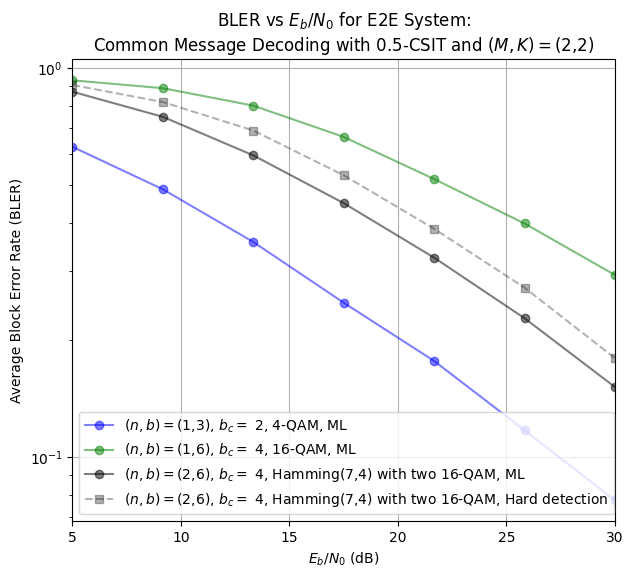

In [ ]:
# Parameters====================================================================
K = 2 # Number of users
M = 2 # Number of BS antennas
T = 1 # Number of time intervals

alph = 0.5 # current CSIT parameter
bet = 0 # delayed CSIT parameter
gam = 1 # CSIR parameter

fig_count = 0
for (simulation_num, modulation_mode, detection_mode) in  [(2,'4-QAM','ML'),(3,'16-QAM','ML'),(4,'Hamming(7,4) with two 16-QAM','ML'),
 (8,'Hamming(7,4) with two 16-QAM','Hard detection')]:
 # (6,'4-QAM','Hard detection'),(7,'16-QAM','Hard detection'),

  print(f'{simulation_num}, {modulation_mode}, {detection_mode}')

  if modulation_mode == '4-QAM':
    b = 3 # number of bits per message
    n = 1 # number of channel use per modulated message
  elif modulation_mode == '16-QAM':
    b = 6 # number of bits per message
    n = 1 # number of channel use per modulated message
  elif modulation_mode == 'Hamming(7,4) with two 16-QAM':
    # 2 symbols of 16-QAM for Hamming(7,4) (bit_per_symbol = 4, channel_use_per_symbol = 2)
    b = 6 # number of bits per message
    n = 2 # number of channel use per modulated message

  n_t = np.ones((T,),dtype=np.int32)*n # Number of channel uses in each time interval
  b_t_k = np.ones((T,K),dtype=np.int32)*b # Number of bits in each user message in a time interval
  b_c = b*K // 3 # Number of bits encoded to the common message

  n_samples_eval = 50_000
  #SNR_dB_eval_num = 7
  #SNR_dB_eval = np.linspace(5,30,SNR_dB_eval_num)
  Eb_N0_dB_eval_num = 7
  Eb_N0_dB_eval = np.linspace(5,30,Eb_N0_dB_eval_num)

  BLER_list = []
  mean_BLER = np.zeros(Eb_N0_dB_eval_num,)

  for i in range(Eb_N0_dB_eval_num):

    # Messages ===
    # Messages of users before splitting:
    messages_indices_list = []
    messages_binary_list = []

    # Private messages of user 0:
    messages_indices_private_0_list = []
    messages_binary_private_0_list = []

    # Private messages of user 1:
    messages_indices_private_1_list = []
    messages_binary_private_1_list = []

    # Common messages:
    messages_indices_common_list = []
    messages_binary_common_list = []

    for t in range(T):
      # User 0:
      bit_per_symbol = b_t_k[t,0]
      messages_t_k0 = np.random.randint(low=0, high=2**bit_per_symbol, size=n_samples_eval, dtype=np.int32)
      messages_t_k0_binary = binary_encoding(messages_t_k0,bit_per_symbol)

      messages_indices_list.append(messages_t_k0) # message indexing
      messages_binary_list.append(messages_t_k0_binary) # binary representation of messages

      # User 1:
      bit_per_symbol = b_t_k[t,1]
      messages_t_k1 = np.random.randint(low=0, high=2**bit_per_symbol, size=n_samples_eval, dtype=np.int32)
      messages_t_k1_binary = binary_encoding(messages_t_k1,bit_per_symbol)

      messages_indices_list.append(messages_t_k1) # message indexing
      messages_binary_list.append(messages_t_k1_binary) # binary representation of messages

      # Rate-Splitting:
      messages_binary_private_0_list.append(messages_t_k0_binary[:,:-(b_c//2)])
      messages_binary_private_1_list.append(messages_t_k1_binary[:,:-(b_c//2)])
      messages_binary_common_t = np.concatenate((messages_t_k0_binary[:,-(b_c//2):], messages_t_k1_binary[:,-(b_c//2):]), axis = -1)
      messages_binary_common_list.append(messages_binary_common_t)

      messages_indices_private_0_list.append(binary_decoding(messages_t_k0_binary[:,:-(b_c//2)], b - b_c//2))
      messages_indices_private_1_list.append(binary_decoding(messages_t_k1_binary[:,:-(b_c//2)], b - b_c//2))
      messages_indices_common_list.append(binary_decoding(messages_binary_common_t, b_c))

    # --- Noise power ---
    #snr = 10**(SNR_dB_eval[i]/10)
    Eb_N0 = 10**(Eb_N0_dB_eval[i]/10)
    snr = np.empty((T,))
    noise_std = np.empty((T,))
    for t in range(T):
      if modulation_mode == 'Hamming(7,4) with two 16-QAM':
        snr[t] = Eb_N0*b*(8/7)/(n_t[t])
      else:
        snr[t] = Eb_N0*b/(n_t[t])
      noise_std[t] = sqrt(0.5/snr[t])


    # Channel ===
    channel_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = np.random.normal(loc=0.0, scale=np.sqrt(0.5), size=[n_samples_eval,K,2*M])
        channel_list.append(channel_t_n)

    # --- CSIR and CSIT ---
    # Current CSIT parameters:
    sigm = np.empty((T,))
    for t in range(T):
      alph_P = alph*snr[t]/(snr[t]+1-alph)
      sigm[t] = snr[t]**(-alph_P)

    # CSIR parameters:
    csir_sigm = np.empty((T,))
    for t in range(T):
      gam_P = gam*snr[t]/(snr[t]+1-gam)
      csir_sigm[t] = snr[t]**(-gam_P)

    csir_list = []
    current_CSIT_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = channel_list[np.sum(n_t[:t]) + n_index]

        # Current CSIT
        current_ch_error_t_n = np.random.normal(loc=0.0, scale=np.sqrt(0.5*sigm[t]), size=[n_samples_eval,K,2*M])
        current_CSIT_list.append(channel_t_n - current_ch_error_t_n)

        # CSIR
        csir_ch_error_t_n = np.random.normal(loc=0.0, scale=np.sqrt(0.5*csir_sigm[t]), size=[n_samples_eval,K,2*M])
        csir_list.append(channel_t_n - csir_ch_error_t_n)

    # --- Tx ---
    # 1. Channel Coding and Modulation
    modulated_signal_private_0_list = [] # modulated signals of private messages of user 0
    modulated_signal_private_1_list = [] # modulated signals of private messages of user 1
    modulated_signal_common_list = [] # modulated signals of common messages
    for t in range(T):
      if modulation_mode == '4-QAM':
        modulated_signal_private_0_list.append(encoding_4QAM_gray_lookup(messages_indices_private_0_list[t]))# shape = (n_samples_eval, 2)
        modulated_signal_private_1_list.append(encoding_4QAM_gray_lookup(messages_indices_private_1_list[t]))# shape = (n_samples_eval, 2)
        modulated_signal_common_list.append(encoding_4QAM_gray_lookup(messages_indices_common_list[t]))# shape = (n_samples_eval, 2)

      elif modulation_mode == '16-QAM':
        modulated_signal_private_0_list.append(encoding_16QAM_gray_lookup(messages_indices_private_0_list[t]))# shape = (n_samples_eval, 2)
        modulated_signal_private_1_list.append(encoding_16QAM_gray_lookup(messages_indices_private_1_list[t]))# shape = (n_samples_eval, 2)
        modulated_signal_common_list.append(encoding_16QAM_gray_lookup(messages_indices_common_list[t]))# shape = (n_samples_eval, 2)

      elif modulation_mode == 'Hamming(7,4) with two 16-QAM':
        # Channel Coding by Hamming(7,4)
        Hamming_codeword_matrix_private_0 = hamming_encode_stream(messages_binary_private_0_list[t])
        Hamming_codeword_matrix_private_1 = hamming_encode_stream(messages_binary_private_1_list[t])
        Hamming_codeword_matrix_common = hamming_encode_stream(messages_binary_common_list[t])

        # Modulation: 2 symbols of 16-QAM for Hamming(7,4) (bit_per_symbol = 4, channel_use_per_symbol = 2)
        modulated_signal_private_0_list.append(modulate_16qam_hamming_7_4(Hamming_codeword_matrix_private_0))# shape: (n_samples_eval,4)
        modulated_signal_private_1_list.append(modulate_16qam_hamming_7_4(Hamming_codeword_matrix_private_1))# shape: (n_samples_eval,4)
        modulated_signal_common_list.append(modulate_16qam_hamming_7_4(Hamming_codeword_matrix_common)) # shape: (n_samples_eval,4)

    # 2. Beamforming and Power allocation
    tx_output_list = []
    W_complex_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        tx_t_n = np.zeros((n_samples_eval,2*M))
        W_complex = np.zeros((n_samples_eval,M,3)) + 1j* np.zeros((n_samples_eval,M,3)) # Beamforming vectors of three streams (one common and two private streams)
        for sample_index in range(n_samples_eval):
          # Channel matrix at transmitter
          H_at_Tx = current_CSIT_list[np.sum(n_t[:t]) + n_index][sample_index,...] # Shape: (K , 2*M)
          H_at_Tx_complex = H_at_Tx[...,:M] + 1j * H_at_Tx[...,M:] # Shape: (K, M)

          # ZF beamforming matrix for private streams
          P_private = (snr[t]**alph/snr[t])
          P_common = 1- P_private
          W_zf = zero_forcing_precoder(H_at_Tx, P_private) # Shape: (2*M , K)
          q0 = W_zf[:M,0] + 1j* W_zf[M:,0]
          q1 = W_zf[:M,1] + 1j* W_zf[M:,1]
          qc = np.sqrt(P_common)*(q0+q1)/np.linalg.norm(q0+q1)
          W_complex[sample_index,:,:] = np.concatenate((qc.reshape(-1,1), q0.reshape(-1,1), q1.reshape(-1,1)), axis = -1)

          # Symbols
          symbol_n_I_private_0 = modulated_signal_private_0_list[t][sample_index,2*n_index]
          symbol_n_Q_private_0 = modulated_signal_private_0_list[t][sample_index,2*n_index + 1]
          symbol_n_private_0 = symbol_n_I_private_0 + 1j * symbol_n_Q_private_0

          symbol_n_I_private_1 = modulated_signal_private_1_list[t][sample_index,2*n_index]
          symbol_n_Q_private_1 = modulated_signal_private_1_list[t][sample_index,2*n_index + 1]
          symbol_n_private_1 = symbol_n_I_private_1 + 1j * symbol_n_Q_private_1

          symbol_n_I_common = modulated_signal_common_list[t][sample_index,2*n_index]
          symbol_n_Q_common = modulated_signal_common_list[t][sample_index,2*n_index + 1]
          symbol_n_common = symbol_n_I_common + 1j * symbol_n_Q_common

          # Applying beamforming
          tx_t_n_complex = q0*symbol_n_private_0 + q1*symbol_n_private_1 + qc*symbol_n_common
          #tx_t_n_complex = tx_t_n_complex / np.linalg.norm(tx_t_n_complex)

          # Real part of the transmitted signal in the nth channel user of time t
          tx_t_n[sample_index,:M] = np.real(tx_t_n_complex)

          # Imaginary part of the transmitted signal in the nth channel user of time t
          tx_t_n[sample_index,M:] = np.imag(tx_t_n_complex)

        tx_output_list.append(tx_t_n)
        W_complex_list.append(W_complex)

    # --- Channel ---
    received_signal_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        received_signal_t_n = np.zeros((n_samples_eval,2*K))
        for sample_index in range(n_samples_eval):
          # Complex channel matrix
          H = channel_list[np.sum(n_t[:t]) + n_index][sample_index,...]# Shape: (K, 2*M)
          H_complex = H[...,:M] + 1j * H[...,M:] # Shape: (K,M)

          # Complex Tx signal
          x = tx_output_list[np.sum(n_t[:t]) + n_index][sample_index,:M] + 1j * tx_output_list[np.sum(n_t[:t]) + n_index][sample_index,M:] # Shape: (M,1)

          # AWGN noise
          noise = np.random.normal(loc=0.0, scale=noise_std[t], size=(K,)) + 1j * np.random.normal(loc=0.0, scale=noise_std[t], size=(K,))

          # Complex received signal
          y = H_complex @ x + noise # Shape: (K,1)
          received_signal_t_n[sample_index,:] = np.concatenate((y.real,y.imag), axis = 0).reshape(2*K,)

        received_signal_list.append(received_signal_t_n)

    # --- Decoder ---
    # Decoding common messages at users 0 and 1 ---
    # 1. Combining Filter
    filtered_output_common_list = []
    for t in range(T):
      for k in range(K):
        filtered_output_common_t_k = np.zeros((n_samples_eval,2*n_t[t]))
        for n_index in range(n_t[t]):
          for sample_index in range(n_samples_eval):
            # Channel matrix at the receiver
            H_at_Rx = csir_list[np.sum(n_t[:t]) + n_index][sample_index,...] # Shape: (K , 2*M)
            H_at_Rx_complex = H_at_Rx[...,:M] + 1j * H_at_Rx[...,M:]

            # Beamforming vector calculated at the receiver: (it is assumed that the receiver knows CSIT as well)
            qc = W_complex_list[np.sum(n_t[:t]) + n_index][sample_index,:,0]

            # Received signal at user k
            y_k = received_signal_list[np.sum(n_t[:t]) + n_index][sample_index, k] + 1j * received_signal_list[np.sum(n_t[:t]) + n_index][sample_index, K + k]
            # Combining factor
            g_k = H_at_Rx_complex[k,:] @ qc
            # Adjusting the received signal
            r_k = (g_k.conj()/(np.linalg.norm(g_k)**2)) * y_k
            # Saving the updates
            filtered_output_common_t_k[sample_index,2*n_index:(2*(n_index + 1))] = np.array([r_k.real,r_k.imag])

        filtered_output_common_list.append(filtered_output_common_t_k)

    # 2. Detection
    messages_indices_common_detected_list = []
    messages_binary_common_detected_list = []
    if detection_mode == 'ML':
      for t in range(T):
          for k in range(K):
            # 1. Received signal of user k in time interval t
            received_symbols = filtered_output_common_list[t * K + k] # Shape: (n_samples_eval,2*n_t[t])

            # 2. Dictionary of messages indices
            data_indices_dict = np.arange(0,2**b_c)
            data_binary_dict = np.array(binary_encoding(data_indices_dict, b_c), dtype=np.uint8)

            # 3. Soft dictionary of encoded and modulated signal
            if modulation_mode == '4-QAM':
              symbol_dict = encoding_4QAM_gray_lookup(data_indices_dict)
            elif modulation_mode == '16-QAM':
              symbol_dict = encoding_16QAM_gray_lookup(data_indices_dict)
            elif modulation_mode == 'Hamming(7,4) with two 16-QAM':
              codeword_dict = hamming_encode_stream(data_binary_dict)
              symbol_dict = modulate_16qam_hamming_7_4(codeword_dict)

            # 4. ML detection
            decoded_bits, decoded_indices = soft_ml_decoder(received_symbols, symbol_dict, data_binary_dict)
            # decoded_bits of shape: (n_samples_eval, b_t_k[t,k])
            # decoded_indices of shape: (n_samples_eval,)

            # 5. Saving detected symbols
            messages_indices_common_detected_list.append(decoded_indices)
            messages_binary_common_detected_list.append(decoded_bits)
    elif detection_mode == 'Hard detection':
      for t in range(T):
        for k in range(K):
          # 1. Received signal of user k in time interval t
          received_symbols = filtered_output_common_list[t * K + k] # Shape: (n_samples_eval,2*n_t[t])

          # 2. Demodulation with hard decision
          if modulation_mode == '4-QAM':
            decoded_bits = decoding_4QAM_gray_hard(received_symbols)
          elif modulation_mode == '16-QAM':
            decoded_bits = decoding_16QAM_gray_hard(received_symbols)
          elif modulation_mode == 'Hamming(7,4) with two 16-QAM':
            # Demodulation:
            code1 = decoding_16QAM_gray_hard(received_symbols[:,:2]) #(c2, c4, c5, c6)
            code2 = decoding_16QAM_gray_hard(received_symbols[:,2:]) #(c0, c1, c3, _)
            codeblock = np.concatenate((code1, code2), axis = -1)
            detected_codeword = codeblock[:,[4,5,0,6,1,2,3]]
            # Channel Decoding
            decoded_bits, _, _ = hamming_decode_correct_stream(detected_codeword)

          # 4. Detecting messages indices
          messages_indices_common_detected_list.append(binary_decoding(decoded_bits, b_t_k[t,k]))
          messages_binary_common_detected_list.append(decoded_bits)


    # Modulating and applying beamforming to the detected common messages to prepare the part must be subtracted from the received signal before decoding the private messages (SIC) ---
    # Modulation
    modulated_common_message_detected_list = []
    for t in range(T):
      for k in range(K):
        if modulation_mode == '4-QAM':
          modulated_common_message_detected_list.append(encoding_4QAM_gray_lookup(messages_indices_common_detected_list[t * K + k]))

        elif modulation_mode == '16-QAM':
          modulated_common_message_detected_list.append(encoding_16QAM_gray_lookup(messages_indices_common_detected_list[t * K + k]))

        elif modulation_mode == 'Hamming(7,4) with two 16-QAM':
          # Channel Coding by Hamming(7,4)
          Hamming_codeword_matrix_common = hamming_encode_stream(messages_binary_common_detected_list[t*K + k])

          # Modulation: 2 symbols of 16-QAM for Hamming(7,4) (bit_per_symbol = 4, channel_use_per_symbol = 2)
          modulated_common_message_detected_list.append(modulate_16qam_hamming_7_4(Hamming_codeword_matrix_common)) # shape: (n_samples_eval,4)

    # Applying beamforming and channel vector
    subtracted_received_signal_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        subtracting_part_t_n = np.zeros((n_samples_eval,2*K))

        for sample_index in range(n_samples_eval):
          # Channel matrix at the receiver
          H_at_Rx = csir_list[np.sum(n_t[:t]) + n_index][sample_index,...] # Shape: (K , 2*M)
          H_at_Rx_complex = H_at_Rx[...,:M] + 1j * H_at_Rx[...,M:]

          for k in range(K):
            # Symbols
            symbol_n_I_common = modulated_common_message_detected_list[t*K + k][sample_index,2*n_index]
            symbol_n_Q_common = modulated_common_message_detected_list[t*K + k][sample_index,2*n_index + 1]
            symbol_n_common = symbol_n_I_common + 1j * symbol_n_Q_common

            # Beamforming vector calculated at the receiver: (it is assumed that the receiver knows CSIT as well)
            qc = W_complex_list[np.sum(n_t[:t]) + n_index][sample_index,:,0]

            # Applying beamforming
            subtracting_part_t_n_complex = H_at_Rx_complex[k,:] @ (qc*symbol_n_common)

            subtracting_part_t_n[sample_index, k] = subtracting_part_t_n_complex.real
            subtracting_part_t_n[sample_index, K + k] = subtracting_part_t_n_complex.imag

        subtracted_received_signal_list.append(received_signal_list[np.sum(n_t[:t]) + n_index] - subtracting_part_t_n)

    # Decoding private messages ---
    # 1. Combining Filter
    filtered_output_list = []
    for t in range(T):
      for k in range(K):
        filtered_output_t_k = np.zeros((n_samples_eval,2*n_t[t]))
        for n_index in range(n_t[t]):
          for sample_index in range(n_samples_eval):
            # Channel matrix at the receiver
            H_at_Rx = csir_list[np.sum(n_t[:t]) + n_index][sample_index,...] # Shape: (K , 2*M)
            H_at_Rx_complex = H_at_Rx[...,:M] + 1j * H_at_Rx[...,M:]

            # Beamforming vector calculated at the receiver: (it is assumed that the receiver knows CSIT as well)
            q_k = W_complex_list[np.sum(n_t[:t]) + n_index][sample_index,:,k+1]

            # Received signal at user k
            y_k = subtracted_received_signal_list[np.sum(n_t[:t]) + n_index][sample_index, k] + 1j * subtracted_received_signal_list[np.sum(n_t[:t]) + n_index][sample_index, K + k]
            # Combining factor
            g_k = H_at_Rx_complex[k,:] @ q_k
            # Adjusting the received signal
            r_k = (g_k.conj()/(np.linalg.norm(g_k)**2)) * y_k
            # Saving the updates
            filtered_output_t_k[sample_index,2*n_index:(2*(n_index + 1))] = np.array([r_k.real,r_k.imag])

        filtered_output_list.append(filtered_output_t_k)

    # 2. Detection
    messages_binary_private_detected_list = []
    if detection_mode == 'ML':
      for t in range(T):
          for k in range(K):
            # 1. Received signal of user k in time interval t
            received_symbols = filtered_output_list[t * K + k] # Shape: (n_samples_eval,2*n_t[t])

            # 2. Dictionary of messages indices
            data_indices_dict = np.arange(0,2**(b_t_k[t,k]-b_c//2))
            data_binary_dict = np.array(binary_encoding(data_indices_dict, b_t_k[t,k]-b_c//2), dtype=np.uint8)

            # 3. Soft dictionary of encoded and modulated signal
            if modulation_mode == '4-QAM':
              symbol_dict = encoding_4QAM_gray_lookup(data_indices_dict)
            elif modulation_mode == '16-QAM':
              symbol_dict = encoding_16QAM_gray_lookup(data_indices_dict)
            elif modulation_mode == 'Hamming(7,4) with two 16-QAM':
              codeword_dict = hamming_encode_stream(data_binary_dict)
              symbol_dict = modulate_16qam_hamming_7_4(codeword_dict)

            # 4. ML detection
            decoded_bits, decoded_indices = soft_ml_decoder(received_symbols, symbol_dict, data_binary_dict)
            # decoded_bits of shape: (n_samples_eval, b_t_k[t,k] - b_c//2)
            # decoded_indices of shape: (n_samples_eval,)

            # 5. Saving detected symbols
            messages_binary_private_detected_list.append(decoded_bits)

    elif detection_mode == 'Hard detection':
      for t in range(T):
        for k in range(K):
          # 1. Received signal of user k in time interval t
          received_symbols = filtered_output_list[t * K + k] # Shape: (n_samples_eval,2*n_t[t])

          # 2. Demodulation with hard decision
          if modulation_mode == '4-QAM':
            decoded_bits = decoding_4QAM_gray_hard(received_symbols)
          elif modulation_mode == '16-QAM':
            decoded_bits = decoding_16QAM_gray_hard(received_symbols)
          elif modulation_mode == 'Hamming(7,4) with two 16-QAM':
            # Demodulation:
            code1 = decoding_16QAM_gray_hard(received_symbols[:,:2]) #(c2, c4, c5, c6)
            code2 = decoding_16QAM_gray_hard(received_symbols[:,2:]) #(c0, c1, c3, _)
            codeblock = np.concatenate((code1, code2), axis = -1)
            detected_codeword = codeblock[:,[4,5,0,6,1,2,3]]
            # Channel Decoding
            decoded_bits, _, _ = hamming_decode_correct_stream(detected_codeword)

          # 4. Detecting messages indices
          messages_binary_private_detected_list.append(decoded_bits)

    # --- Concatenating detected messages ---
    messages_indices_detected_list = []
    for t in range(T):
      for k in range(K):
        if k == 0:
          detected_binary_message_k = np.concatenate((messages_binary_private_detected_list[t*K + k], messages_binary_common_detected_list[t*K + k][:,:b_c//2]),axis = -1)
        else:
          detected_binary_message_k = np.concatenate((messages_binary_private_detected_list[t*K + k], messages_binary_common_detected_list[t*K + k][:,b_c//2:]),axis = -1)

        messages_indices_detected_list.append(binary_decoding(detected_binary_message_k, b_t_k[t,k]))

    # --- BLER calculation ---
    BLER = np.zeros((T, K))
    mean_BLER_count = 0
    for t in range(T):
      for k in range(K):
        BLER[t,k] = np.count_nonzero(messages_indices_list[t * K + k] !=
                                      messages_indices_detected_list[t * K + k]) / n_samples_eval
        mean_BLER[i] = mean_BLER[i] + BLER[t,k]
    #print(BLER)
    BLER_list.append(BLER)
    mean_BLER[i] = mean_BLER[i]/(T*K)

  if simulation_num == 2:
    mean_BLER2 = np.array(mean_BLER)
    label2 = r'$(n,b)=$' + f'({n},{b}), ' + r'$b_c=$ ' + f'{b_c}, {modulation_mode}, {detection_mode}'
  elif simulation_num == 3:
    mean_BLER3 = np.array(mean_BLER)
    label3 = r'$(n,b)=$' + f'({n},{b}), ' + r'$b_c=$ ' + f'{b_c}, {modulation_mode}, {detection_mode}'
  elif simulation_num == 4:
    mean_BLER4 = np.array(mean_BLER)
    label4 = r'$(n,b)=$' + f'({n},{b}), ' + r'$b_c=$ ' + f'{b_c}, {modulation_mode}, {detection_mode}'
  elif simulation_num == 6:
    mean_BLER6 = np.array(mean_BLER)
    label6 = r'$(n,b)=$' + f'({n},{b}), ' + r'$b_c=$ ' + f'{b_c}, {modulation_mode}, {detection_mode}'
  elif simulation_num == 7:
    mean_BLER7 = np.array(mean_BLER)
    label7 = r'$(n,b)=$' + f'({n},{b}), ' + r'$b_c=$ ' + f'{b_c}, {modulation_mode}, {detection_mode}'
  elif simulation_num == 8:
    mean_BLER8 = np.array(mean_BLER)
    label8 = r'$(n,b)=$' + f'({n},{b}), ' + r'$b_c=$ ' + f'{b_c}, {modulation_mode}, {detection_mode}'

# --- BLER plot ---
plt.figure(fig_count+1,figsize=(7, 6))
BLER_plot2, = plt.plot(Eb_N0_dB_eval, mean_BLER2, 'b-o', label = label2)
BLER_plot2.set_alpha(0.5)
BLER_plot3, = plt.plot(Eb_N0_dB_eval, mean_BLER3, 'g-o', label = label3)
BLER_plot3.set_alpha(0.5)
BLER_plot4, = plt.plot(Eb_N0_dB_eval, mean_BLER4, 'k-o', label = label4)
BLER_plot4.set_alpha(0.5)
#BLER_plot6, = plt.plot(Eb_N0_dB_eval, mean_BLER6, 'b--s', label = label6)
#BLER_plot6.set_alpha(0.3)
#BLER_plot7, = plt.plot(Eb_N0_dB_eval, mean_BLER7, 'g--s', label = label7)
#BLER_plot7.set_alpha(0.3)
BLER_plot8, = plt.plot(Eb_N0_dB_eval, mean_BLER8, 'k--s', label = label8)
BLER_plot8.set_alpha(0.3)
plt.legend(loc = 'best')
plt.xlabel(r'$E_b/N_0$' + ' (dB)')
plt.ylabel('Average Block Error Rate (BLER)')
plt.xlim([min(Eb_N0_dB_eval),max(Eb_N0_dB_eval)])
plt.yscale("log")
plt.title('BLER vs ' + r'$E_b/N_0$' + f' for E2E System:\nCommon Message Decoding with {alph}-CSIT and ' + r'$(M,K)=$' + f'({M},{K})')
plt.grid()
plt.savefig(f'BLER_RSMA_{alph}.png')

## 10.2. M=K=4

In [ ]:
# Parameters====================================================================
K = 2 # Number of users
M = 2 # Number of BS antennas
T = 1 # Number of time intervals

alph = 0.5 # current CSIT parameter
bet = 0 # delayed CSIT parameter
gam = 1 # CSIR parameter

fig_count = 0
for (simulation_num, modulation_mode, detection_mode) in  [(2,'4-QAM','ML'),(3,'16-QAM','ML'),(4,'Hamming(7,4) with two 16-QAM','ML'),
 (8,'Hamming(7,4) with two 16-QAM','Hard detection')]:
 # (6,'4-QAM','Hard detection'),(7,'16-QAM','Hard detection'),

  print(f'{simulation_num}, {modulation_mode}, {detection_mode}')

  if modulation_mode == '4-QAM':
    b = 3 # number of bits per message
    n = 1 # number of channel use per modulated message
  elif modulation_mode == '16-QAM':
    b = 6 # number of bits per message
    n = 1 # number of channel use per modulated message
  elif modulation_mode == 'Hamming(7,4) with two 16-QAM':
    # 2 symbols of 16-QAM for Hamming(7,4) (bit_per_symbol = 4, channel_use_per_symbol = 2)
    b = 6 # number of bits per message
    n = 2 # number of channel use per modulated message

  n_t = np.ones((T,),dtype=np.int32)*n # Number of channel uses in each time interval
  b_t_k = np.ones((T,K),dtype=np.int32)*b # Number of bits in each user message in a time interval
  b_c = b*K // 3 # Number of bits encoded to the common message

  n_samples_eval = 50_000
  #SNR_dB_eval_num = 7
  #SNR_dB_eval = np.linspace(5,30,SNR_dB_eval_num)
  Eb_N0_dB_eval_num = 7
  Eb_N0_dB_eval = np.linspace(5,30,Eb_N0_dB_eval_num)

  BLER_list = []
  mean_BLER = np.zeros(Eb_N0_dB_eval_num,)

  for i in range(Eb_N0_dB_eval_num):

    # Messages ===
    # Messages of users before splitting:
    messages_indices_list = []
    messages_binary_list = []

    # Private messages of user 0:
    messages_indices_private_0_list = []
    messages_binary_private_0_list = []

    # Private messages of user 1:
    messages_indices_private_1_list = []
    messages_binary_private_1_list = []

    # Common messages:
    messages_indices_common_list = []
    messages_binary_common_list = []

    for t in range(T):
      # User 0:
      bit_per_symbol = b_t_k[t,0]
      messages_t_k0 = np.random.randint(low=0, high=2**bit_per_symbol, size=n_samples_eval, dtype=np.int32)
      messages_t_k0_binary = binary_encoding(messages_t_k0,bit_per_symbol)

      messages_indices_list.append(messages_t_k0) # message indexing
      messages_binary_list.append(messages_t_k0_binary) # binary representation of messages

      # User 1:
      bit_per_symbol = b_t_k[t,1]
      messages_t_k1 = np.random.randint(low=0, high=2**bit_per_symbol, size=n_samples_eval, dtype=np.int32)
      messages_t_k1_binary = binary_encoding(messages_t_k1,bit_per_symbol)

      messages_indices_list.append(messages_t_k1) # message indexing
      messages_binary_list.append(messages_t_k1_binary) # binary representation of messages

      # Rate-Splitting:
      messages_binary_private_0_list.append(messages_t_k0_binary[:,:-(b_c//2)])
      messages_binary_private_1_list.append(messages_t_k1_binary[:,:-(b_c//2)])
      messages_binary_common_t = np.concatenate((messages_t_k0_binary[:,-(b_c//2):], messages_t_k1_binary[:,-(b_c//2):]), axis = -1)
      messages_binary_common_list.append(messages_binary_common_t)

      messages_indices_private_0_list.append(binary_decoding(messages_t_k0_binary[:,:-(b_c//2)], b - b_c//2))
      messages_indices_private_1_list.append(binary_decoding(messages_t_k1_binary[:,:-(b_c//2)], b - b_c//2))
      messages_indices_common_list.append(binary_decoding(messages_binary_common_t, b_c))

    # --- Noise power ---
    #snr = 10**(SNR_dB_eval[i]/10)
    Eb_N0 = 10**(Eb_N0_dB_eval[i]/10)
    snr = np.empty((T,))
    noise_std = np.empty((T,))
    for t in range(T):
      if modulation_mode == 'Hamming(7,4) with two 16-QAM':
        snr[t] = Eb_N0*b*(8/7)/(n_t[t])
      else:
        snr[t] = Eb_N0*b/(n_t[t])
      noise_std[t] = sqrt(0.5/snr[t])


    # Channel ===
    channel_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = np.random.normal(loc=0.0, scale=np.sqrt(0.5), size=[n_samples_eval,K,2*M])
        channel_list.append(channel_t_n)

    # --- CSIR and CSIT ---
    # Current CSIT parameters:
    sigm = np.empty((T,))
    for t in range(T):
      alph_P = alph*snr[t]/(snr[t]+1-alph)
      sigm[t] = snr[t]**(-alph_P)

    # CSIR parameters:
    csir_sigm = np.empty((T,))
    for t in range(T):
      gam_P = gam*snr[t]/(snr[t]+1-gam)
      csir_sigm[t] = snr[t]**(-gam_P)

    csir_list = []
    current_CSIT_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = channel_list[np.sum(n_t[:t]) + n_index]

        # Current CSIT
        current_ch_error_t_n = np.random.normal(loc=0.0, scale=np.sqrt(0.5*sigm[t]), size=[n_samples_eval,K,2*M])
        current_CSIT_list.append(channel_t_n - current_ch_error_t_n)

        # CSIR
        csir_ch_error_t_n = np.random.normal(loc=0.0, scale=np.sqrt(0.5*csir_sigm[t]), size=[n_samples_eval,K,2*M])
        csir_list.append(channel_t_n - csir_ch_error_t_n)

    # --- Tx ---
    # 1. Channel Coding and Modulation
    modulated_signal_private_0_list = [] # modulated signals of private messages of user 0
    modulated_signal_private_1_list = [] # modulated signals of private messages of user 1
    modulated_signal_common_list = [] # modulated signals of common messages
    for t in range(T):
      if modulation_mode == '4-QAM':
        modulated_signal_private_0_list.append(encoding_4QAM_gray_lookup(messages_indices_private_0_list[t]))# shape = (n_samples_eval, 2)
        modulated_signal_private_1_list.append(encoding_4QAM_gray_lookup(messages_indices_private_1_list[t]))# shape = (n_samples_eval, 2)
        modulated_signal_common_list.append(encoding_4QAM_gray_lookup(messages_indices_common_list[t]))# shape = (n_samples_eval, 2)

      elif modulation_mode == '16-QAM':
        modulated_signal_private_0_list.append(encoding_16QAM_gray_lookup(messages_indices_private_0_list[t]))# shape = (n_samples_eval, 2)
        modulated_signal_private_1_list.append(encoding_16QAM_gray_lookup(messages_indices_private_1_list[t]))# shape = (n_samples_eval, 2)
        modulated_signal_common_list.append(encoding_16QAM_gray_lookup(messages_indices_common_list[t]))# shape = (n_samples_eval, 2)

      elif modulation_mode == 'Hamming(7,4) with two 16-QAM':
        # Channel Coding by Hamming(7,4)
        Hamming_codeword_matrix_private_0 = hamming_encode_stream(messages_binary_private_0_list[t])
        Hamming_codeword_matrix_private_1 = hamming_encode_stream(messages_binary_private_1_list[t])
        Hamming_codeword_matrix_common = hamming_encode_stream(messages_binary_common_list[t])

        # Modulation: 2 symbols of 16-QAM for Hamming(7,4) (bit_per_symbol = 4, channel_use_per_symbol = 2)
        modulated_signal_private_0_list.append(modulate_16qam_hamming_7_4(Hamming_codeword_matrix_private_0))# shape: (n_samples_eval,4)
        modulated_signal_private_1_list.append(modulate_16qam_hamming_7_4(Hamming_codeword_matrix_private_1))# shape: (n_samples_eval,4)
        modulated_signal_common_list.append(modulate_16qam_hamming_7_4(Hamming_codeword_matrix_common)) # shape: (n_samples_eval,4)

    # 2. Beamforming and Power allocation
    tx_output_list = []
    W_complex_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        tx_t_n = np.zeros((n_samples_eval,2*M))
        W_complex = np.zeros((n_samples_eval,M,3)) + 1j* np.zeros((n_samples_eval,M,3)) # Beamforming vectors of three streams (one common and two private streams)
        for sample_index in range(n_samples_eval):
          # Channel matrix at transmitter
          H_at_Tx = current_CSIT_list[np.sum(n_t[:t]) + n_index][sample_index,...] # Shape: (K , 2*M)
          H_at_Tx_complex = H_at_Tx[...,:M] + 1j * H_at_Tx[...,M:] # Shape: (K, M)

          # ZF beamforming matrix for private streams
          P_private = (snr[t]**alph/snr[t])
          P_common = 1- P_private
          W_zf = zero_forcing_precoder(H_at_Tx, P_private) # Shape: (2*M , K)
          q0 = W_zf[:M,0] + 1j* W_zf[M:,0]
          q1 = W_zf[:M,1] + 1j* W_zf[M:,1]
          qc = np.sqrt(P_common)*(q0+q1)/np.linalg.norm(q0+q1)
          W_complex[sample_index,:,:] = np.concatenate((qc.reshape(-1,1), q0.reshape(-1,1), q1.reshape(-1,1)), axis = -1)

          # Symbols
          symbol_n_I_private_0 = modulated_signal_private_0_list[t][sample_index,2*n_index]
          symbol_n_Q_private_0 = modulated_signal_private_0_list[t][sample_index,2*n_index + 1]
          symbol_n_private_0 = symbol_n_I_private_0 + 1j * symbol_n_Q_private_0

          symbol_n_I_private_1 = modulated_signal_private_1_list[t][sample_index,2*n_index]
          symbol_n_Q_private_1 = modulated_signal_private_1_list[t][sample_index,2*n_index + 1]
          symbol_n_private_1 = symbol_n_I_private_1 + 1j * symbol_n_Q_private_1

          symbol_n_I_common = modulated_signal_common_list[t][sample_index,2*n_index]
          symbol_n_Q_common = modulated_signal_common_list[t][sample_index,2*n_index + 1]
          symbol_n_common = symbol_n_I_common + 1j * symbol_n_Q_common

          # Applying beamforming
          tx_t_n_complex = q0*symbol_n_private_0 + q1*symbol_n_private_1 + qc*symbol_n_common
          #tx_t_n_complex = tx_t_n_complex / np.linalg.norm(tx_t_n_complex)

          # Real part of the transmitted signal in the nth channel user of time t
          tx_t_n[sample_index,:M] = np.real(tx_t_n_complex)

          # Imaginary part of the transmitted signal in the nth channel user of time t
          tx_t_n[sample_index,M:] = np.imag(tx_t_n_complex)

        tx_output_list.append(tx_t_n)
        W_complex_list.append(W_complex)

    # --- Channel ---
    received_signal_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        received_signal_t_n = np.zeros((n_samples_eval,2*K))
        for sample_index in range(n_samples_eval):
          # Complex channel matrix
          H = channel_list[np.sum(n_t[:t]) + n_index][sample_index,...]# Shape: (K, 2*M)
          H_complex = H[...,:M] + 1j * H[...,M:] # Shape: (K,M)

          # Complex Tx signal
          x = tx_output_list[np.sum(n_t[:t]) + n_index][sample_index,:M] + 1j * tx_output_list[np.sum(n_t[:t]) + n_index][sample_index,M:] # Shape: (M,1)

          # AWGN noise
          noise = np.random.normal(loc=0.0, scale=noise_std[t], size=(K,)) + 1j * np.random.normal(loc=0.0, scale=noise_std[t], size=(K,))

          # Complex received signal
          y = H_complex @ x + noise # Shape: (K,1)
          received_signal_t_n[sample_index,:] = np.concatenate((y.real,y.imag), axis = 0).reshape(2*K,)

        received_signal_list.append(received_signal_t_n)

    # --- Decoder ---
    # Decoding common messages at users 0 and 1 ---
    # 1. Combining Filter
    filtered_output_common_list = []
    for t in range(T):
      for k in range(K):
        filtered_output_common_t_k = np.zeros((n_samples_eval,2*n_t[t]))
        for n_index in range(n_t[t]):
          for sample_index in range(n_samples_eval):
            # Channel matrix at the receiver
            H_at_Rx = csir_list[np.sum(n_t[:t]) + n_index][sample_index,...] # Shape: (K , 2*M)
            H_at_Rx_complex = H_at_Rx[...,:M] + 1j * H_at_Rx[...,M:]

            # Beamforming vector calculated at the receiver: (it is assumed that the receiver knows CSIT as well)
            qc = W_complex_list[np.sum(n_t[:t]) + n_index][sample_index,:,0]

            # Received signal at user k
            y_k = received_signal_list[np.sum(n_t[:t]) + n_index][sample_index, k] + 1j * received_signal_list[np.sum(n_t[:t]) + n_index][sample_index, K + k]
            # Combining factor
            g_k = H_at_Rx_complex[k,:] @ qc
            # Adjusting the received signal
            r_k = (g_k.conj()/(np.linalg.norm(g_k)**2)) * y_k
            # Saving the updates
            filtered_output_common_t_k[sample_index,2*n_index:(2*(n_index + 1))] = np.array([r_k.real,r_k.imag])

        filtered_output_common_list.append(filtered_output_common_t_k)

    # 2. Detection
    messages_indices_common_detected_list = []
    messages_binary_common_detected_list = []
    if detection_mode == 'ML':
      for t in range(T):
          for k in range(K):
            # 1. Received signal of user k in time interval t
            received_symbols = filtered_output_common_list[t * K + k] # Shape: (n_samples_eval,2*n_t[t])

            # 2. Dictionary of messages indices
            data_indices_dict = np.arange(0,2**b_c)
            data_binary_dict = np.array(binary_encoding(data_indices_dict, b_c), dtype=np.uint8)

            # 3. Soft dictionary of encoded and modulated signal
            if modulation_mode == '4-QAM':
              symbol_dict = encoding_4QAM_gray_lookup(data_indices_dict)
            elif modulation_mode == '16-QAM':
              symbol_dict = encoding_16QAM_gray_lookup(data_indices_dict)
            elif modulation_mode == 'Hamming(7,4) with two 16-QAM':
              codeword_dict = hamming_encode_stream(data_binary_dict)
              symbol_dict = modulate_16qam_hamming_7_4(codeword_dict)

            # 4. ML detection
            decoded_bits, decoded_indices = soft_ml_decoder(received_symbols, symbol_dict, data_binary_dict)
            # decoded_bits of shape: (n_samples_eval, b_t_k[t,k])
            # decoded_indices of shape: (n_samples_eval,)

            # 5. Saving detected symbols
            messages_indices_common_detected_list.append(decoded_indices)
            messages_binary_common_detected_list.append(decoded_bits)
    elif detection_mode == 'Hard detection':
      for t in range(T):
        for k in range(K):
          # 1. Received signal of user k in time interval t
          received_symbols = filtered_output_common_list[t * K + k] # Shape: (n_samples_eval,2*n_t[t])

          # 2. Demodulation with hard decision
          if modulation_mode == '4-QAM':
            decoded_bits = decoding_4QAM_gray_hard(received_symbols)
          elif modulation_mode == '16-QAM':
            decoded_bits = decoding_16QAM_gray_hard(received_symbols)
          elif modulation_mode == 'Hamming(7,4) with two 16-QAM':
            # Demodulation:
            code1 = decoding_16QAM_gray_hard(received_symbols[:,:2]) #(c2, c4, c5, c6)
            code2 = decoding_16QAM_gray_hard(received_symbols[:,2:]) #(c0, c1, c3, _)
            codeblock = np.concatenate((code1, code2), axis = -1)
            detected_codeword = codeblock[:,[4,5,0,6,1,2,3]]
            # Channel Decoding
            decoded_bits, _, _ = hamming_decode_correct_stream(detected_codeword)

          # 4. Detecting messages indices
          messages_indices_common_detected_list.append(binary_decoding(decoded_bits, b_t_k[t,k]))
          messages_binary_common_detected_list.append(decoded_bits)


    # Modulating and applying beamforming to the detected common messages to prepare the part must be subtracted from the received signal before decoding the private messages (SIC) ---
    # Modulation
    modulated_common_message_detected_list = []
    for t in range(T):
      for k in range(K):
        if modulation_mode == '4-QAM':
          modulated_common_message_detected_list.append(encoding_4QAM_gray_lookup(messages_indices_common_detected_list[t * K + k]))

        elif modulation_mode == '16-QAM':
          modulated_common_message_detected_list.append(encoding_16QAM_gray_lookup(messages_indices_common_detected_list[t * K + k]))

        elif modulation_mode == 'Hamming(7,4) with two 16-QAM':
          # Channel Coding by Hamming(7,4)
          Hamming_codeword_matrix_common = hamming_encode_stream(messages_binary_common_detected_list[t*K + k])

          # Modulation: 2 symbols of 16-QAM for Hamming(7,4) (bit_per_symbol = 4, channel_use_per_symbol = 2)
          modulated_common_message_detected_list.append(modulate_16qam_hamming_7_4(Hamming_codeword_matrix_common)) # shape: (n_samples_eval,4)

    # Applying beamforming and channel vector
    subtracted_received_signal_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        subtracting_part_t_n = np.zeros((n_samples_eval,2*K))

        for sample_index in range(n_samples_eval):
          # Channel matrix at the receiver
          H_at_Rx = csir_list[np.sum(n_t[:t]) + n_index][sample_index,...] # Shape: (K , 2*M)
          H_at_Rx_complex = H_at_Rx[...,:M] + 1j * H_at_Rx[...,M:]

          for k in range(K):
            # Symbols
            symbol_n_I_common = modulated_common_message_detected_list[t*K + k][sample_index,2*n_index]
            symbol_n_Q_common = modulated_common_message_detected_list[t*K + k][sample_index,2*n_index + 1]
            symbol_n_common = symbol_n_I_common + 1j * symbol_n_Q_common

            # Beamforming vector calculated at the receiver: (it is assumed that the receiver knows CSIT as well)
            qc = W_complex_list[np.sum(n_t[:t]) + n_index][sample_index,:,0]

            # Applying beamforming
            subtracting_part_t_n_complex = H_at_Rx_complex[k,:] @ (qc*symbol_n_common)

            subtracting_part_t_n[sample_index, k] = subtracting_part_t_n_complex.real
            subtracting_part_t_n[sample_index, K + k] = subtracting_part_t_n_complex.imag

        subtracted_received_signal_list.append(received_signal_list[np.sum(n_t[:t]) + n_index] - subtracting_part_t_n)

    # Decoding private messages ---
    # 1. Combining Filter
    filtered_output_list = []
    for t in range(T):
      for k in range(K):
        filtered_output_t_k = np.zeros((n_samples_eval,2*n_t[t]))
        for n_index in range(n_t[t]):
          for sample_index in range(n_samples_eval):
            # Channel matrix at the receiver
            H_at_Rx = csir_list[np.sum(n_t[:t]) + n_index][sample_index,...] # Shape: (K , 2*M)
            H_at_Rx_complex = H_at_Rx[...,:M] + 1j * H_at_Rx[...,M:]

            # Beamforming vector calculated at the receiver: (it is assumed that the receiver knows CSIT as well)
            q_k = W_complex_list[np.sum(n_t[:t]) + n_index][sample_index,:,k+1]

            # Received signal at user k
            y_k = subtracted_received_signal_list[np.sum(n_t[:t]) + n_index][sample_index, k] + 1j * subtracted_received_signal_list[np.sum(n_t[:t]) + n_index][sample_index, K + k]
            # Combining factor
            g_k = H_at_Rx_complex[k,:] @ q_k
            # Adjusting the received signal
            r_k = (g_k.conj()/(np.linalg.norm(g_k)**2)) * y_k
            # Saving the updates
            filtered_output_t_k[sample_index,2*n_index:(2*(n_index + 1))] = np.array([r_k.real,r_k.imag])

        filtered_output_list.append(filtered_output_t_k)

    # 2. Detection
    messages_binary_private_detected_list = []
    if detection_mode == 'ML':
      for t in range(T):
          for k in range(K):
            # 1. Received signal of user k in time interval t
            received_symbols = filtered_output_list[t * K + k] # Shape: (n_samples_eval,2*n_t[t])

            # 2. Dictionary of messages indices
            data_indices_dict = np.arange(0,2**(b_t_k[t,k]-b_c//2))
            data_binary_dict = np.array(binary_encoding(data_indices_dict, b_t_k[t,k]-b_c//2), dtype=np.uint8)

            # 3. Soft dictionary of encoded and modulated signal
            if modulation_mode == '4-QAM':
              symbol_dict = encoding_4QAM_gray_lookup(data_indices_dict)
            elif modulation_mode == '16-QAM':
              symbol_dict = encoding_16QAM_gray_lookup(data_indices_dict)
            elif modulation_mode == 'Hamming(7,4) with two 16-QAM':
              codeword_dict = hamming_encode_stream(data_binary_dict)
              symbol_dict = modulate_16qam_hamming_7_4(codeword_dict)

            # 4. ML detection
            decoded_bits, decoded_indices = soft_ml_decoder(received_symbols, symbol_dict, data_binary_dict)
            # decoded_bits of shape: (n_samples_eval, b_t_k[t,k] - b_c//2)
            # decoded_indices of shape: (n_samples_eval,)

            # 5. Saving detected symbols
            messages_binary_private_detected_list.append(decoded_bits)

    elif detection_mode == 'Hard detection':
      for t in range(T):
        for k in range(K):
          # 1. Received signal of user k in time interval t
          received_symbols = filtered_output_list[t * K + k] # Shape: (n_samples_eval,2*n_t[t])

          # 2. Demodulation with hard decision
          if modulation_mode == '4-QAM':
            decoded_bits = decoding_4QAM_gray_hard(received_symbols)
          elif modulation_mode == '16-QAM':
            decoded_bits = decoding_16QAM_gray_hard(received_symbols)
          elif modulation_mode == 'Hamming(7,4) with two 16-QAM':
            # Demodulation:
            code1 = decoding_16QAM_gray_hard(received_symbols[:,:2]) #(c2, c4, c5, c6)
            code2 = decoding_16QAM_gray_hard(received_symbols[:,2:]) #(c0, c1, c3, _)
            codeblock = np.concatenate((code1, code2), axis = -1)
            detected_codeword = codeblock[:,[4,5,0,6,1,2,3]]
            # Channel Decoding
            decoded_bits, _, _ = hamming_decode_correct_stream(detected_codeword)

          # 4. Detecting messages indices
          messages_binary_private_detected_list.append(decoded_bits)

    # --- Concatenating detected messages ---
    messages_indices_detected_list = []
    for t in range(T):
      for k in range(K):
        if k == 0:
          detected_binary_message_k = np.concatenate((messages_binary_private_detected_list[t*K + k], messages_binary_common_detected_list[t*K + k][:,:b_c//2]),axis = -1)
        else:
          detected_binary_message_k = np.concatenate((messages_binary_private_detected_list[t*K + k], messages_binary_common_detected_list[t*K + k][:,b_c//2:]),axis = -1)

        messages_indices_detected_list.append(binary_decoding(detected_binary_message_k, b_t_k[t,k]))

    # --- BLER calculation ---
    BLER = np.zeros((T, K))
    mean_BLER_count = 0
    for t in range(T):
      for k in range(K):
        BLER[t,k] = np.count_nonzero(messages_indices_list[t * K + k] !=
                                      messages_indices_detected_list[t * K + k]) / n_samples_eval
        mean_BLER[i] = mean_BLER[i] + BLER[t,k]
    #print(BLER)
    BLER_list.append(BLER)
    mean_BLER[i] = mean_BLER[i]/(T*K)

  if simulation_num == 2:
    mean_BLER2 = np.array(mean_BLER)
    label2 = r'$(n,b)=$' + f'({n},{b}), ' + r'$b_c=$ ' + f'{b_c}, {modulation_mode}, {detection_mode}'
  elif simulation_num == 3:
    mean_BLER3 = np.array(mean_BLER)
    label3 = r'$(n,b)=$' + f'({n},{b}), ' + r'$b_c=$ ' + f'{b_c}, {modulation_mode}, {detection_mode}'
  elif simulation_num == 4:
    mean_BLER4 = np.array(mean_BLER)
    label4 = r'$(n,b)=$' + f'({n},{b}), ' + r'$b_c=$ ' + f'{b_c}, {modulation_mode}, {detection_mode}'
  elif simulation_num == 6:
    mean_BLER6 = np.array(mean_BLER)
    label6 = r'$(n,b)=$' + f'({n},{b}), ' + r'$b_c=$ ' + f'{b_c}, {modulation_mode}, {detection_mode}'
  elif simulation_num == 7:
    mean_BLER7 = np.array(mean_BLER)
    label7 = r'$(n,b)=$' + f'({n},{b}), ' + r'$b_c=$ ' + f'{b_c}, {modulation_mode}, {detection_mode}'
  elif simulation_num == 8:
    mean_BLER8 = np.array(mean_BLER)
    label8 = r'$(n,b)=$' + f'({n},{b}), ' + r'$b_c=$ ' + f'{b_c}, {modulation_mode}, {detection_mode}'

# --- BLER plot ---
plt.figure(fig_count+1,figsize=(7, 6))
BLER_plot2, = plt.plot(Eb_N0_dB_eval, mean_BLER2, 'b-o', label = label2)
BLER_plot2.set_alpha(0.5)
BLER_plot3, = plt.plot(Eb_N0_dB_eval, mean_BLER3, 'g-o', label = label3)
BLER_plot3.set_alpha(0.5)
BLER_plot4, = plt.plot(Eb_N0_dB_eval, mean_BLER4, 'k-o', label = label4)
BLER_plot4.set_alpha(0.5)
#BLER_plot6, = plt.plot(Eb_N0_dB_eval, mean_BLER6, 'b--s', label = label6)
#BLER_plot6.set_alpha(0.3)
#BLER_plot7, = plt.plot(Eb_N0_dB_eval, mean_BLER7, 'g--s', label = label7)
#BLER_plot7.set_alpha(0.3)
BLER_plot8, = plt.plot(Eb_N0_dB_eval, mean_BLER8, 'k--s', label = label8)
BLER_plot8.set_alpha(0.3)
plt.legend(loc = 'best')
plt.xlabel(r'$E_b/N_0$' + ' (dB)')
plt.ylabel('Average Block Error Rate (BLER)')
plt.xlim([min(Eb_N0_dB_eval),max(Eb_N0_dB_eval)])
plt.yscale("log")
plt.title('BLER vs ' + r'$E_b/N_0$' + f' for E2E System:\nCommon Message Decoding with {alph}-CSIT and ' + r'$(M,K)=$' + f'({M},{K})')
plt.grid()
plt.savefig(f'BLER_RSMA_{alph}.png')

# 11. E2E: Time-Correlated Scheme

1, 16-QAM, Two 4-QAMs, ML, $\alpha=$0.5
2, 16-QAM, Two 4-QAMs, ML, $\alpha=$0.6
3, 16-QAM, Two 4-QAMs, ML, $\alpha=$0.7


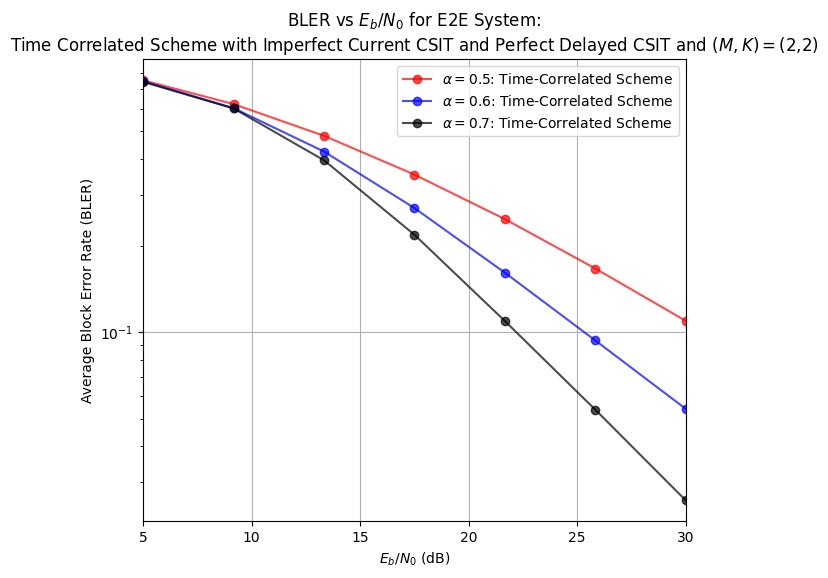

In [ ]:
# Parameters====================================================================
K = 2 # Number of users
M = 2 # Number of BS antennas
T = 2 # Number of time intervals

bet = 1 # delayed CSIT parameter
gam = 1 # CSIR parameter

fig_count = 0
for (simulation_num, alph) in  [(1, 0.5), (2, 0.6), (3, 0.7)]:

  modulation_mode_0 = '16-QAM'
  modulation_mode_1 = 'Two 4-QAMs'
  detection_mode = 'ML'

  print(f'{simulation_num}, {modulation_mode_0}, {modulation_mode_1}, {detection_mode}, ' + r'$\alpha=$' + f'{alph}')

  b = 4
  b_c = 4
  n_t = np.array([1, 2]) # Number of channel uses in each time interval
  b_t_k = np.ones((T,K),dtype=np.int32)*b # Number of bits in each user message in a time interval

  n_samples_eval = 100_000
  Eb_N0_dB_eval_num = 7
  Eb_N0_dB_eval = np.linspace(5,30,Eb_N0_dB_eval_num)

  BLER_list = []
  mean_BLER = np.zeros(Eb_N0_dB_eval_num,)

  for i in range(Eb_N0_dB_eval_num):
    # Messages ===
    messages_indices_list = []
    messages_binary_list = []
    for t in range(T):
      for k in range(K):
        bit_per_symbol = b_t_k[t,k]
        messages_t_k = np.random.randint(low=0, high=2**bit_per_symbol, size=n_samples_eval, dtype=np.int32)
        messages_indices_list.append(messages_t_k) # message indexing
        messages_binary_list.append(binary_encoding(messages_t_k,bit_per_symbol)) # binary representation of messages

    # --- Noise power ---
    Eb_N0 = 10**(Eb_N0_dB_eval[i]/10)
    snr = np.ones((T,))*Eb_N0*4
    noise_std = np.sqrt(0.5/snr[0])*np.ones((T,))


    # Channel ===
    channel_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = np.random.normal(loc=0.0, scale=np.sqrt(0.5), size=[n_samples_eval,K,2*M])
        channel_list.append(channel_t_n)

    # --- CSIR and CSIT ---
    # Delayed CSIT parameters:
    sigma_FB = np.empty((T,))
    for t in range(T):
      bet_P = bet*snr[t]/(snr[t]+1-bet)
      sigma_FB[t] = snr[t]**(-bet_P)

    # Current CSIT parameters:
    sigm = np.empty((T,))
    for t in range(T):
      alph_P = alph*snr[t]/(snr[t]+1-alph)
      sigm[t] = snr[t]**(-alph_P)

    # CSIR parameters:
    csir_sigm = np.empty((T,))
    for t in range(T):
      gam_P = gam*snr[t]/(snr[t]+1-gam)
      csir_sigm[t] = snr[t]**(-gam_P)

    csir_list = []
    current_CSIT_list = []
    delayed_CSIT_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = channel_list[np.sum(n_t[:t]) + n_index]

        # Delayed CSIT
        if t < T-1:
          delayed_ch_error_t_n = np.random.normal(loc=0.0, scale=np.sqrt(0.5*sigma_FB[t]), size=[n_samples_eval,K,2*M])
          delayed_CSIT_list.append(channel_t_n - delayed_ch_error_t_n)

        # Current CSIT
        current_ch_error_t_n = np.random.normal(loc=0.0, scale=np.sqrt(0.5*sigm[t]), size=[n_samples_eval,K,2*M])
        current_CSIT_list.append(channel_t_n - current_ch_error_t_n)

        # CSIR
        csir_ch_error_t_n = np.random.normal(loc=0.0, scale=np.sqrt(0.5*csir_sigm[t]), size=[n_samples_eval,K,2*M])
        csir_list.append(channel_t_n - csir_ch_error_t_n)

    # --- Tx ---
    # 1. Modulation and beamforming of first time interval---

    # 1.1. Modulation for the first time interval is 16-QAM ((n,b) = (1, 4))
    t = 0
    modulated_signal_list_0 = [] # modulated_signal_list_0[k] is of shape (n_samples_eval,2), where 2 is for I and Q part of symbol in each channel use
    for k in range(K):
      modulated_signal_list_0.append(encoding_16QAM_gray_lookup(messages_indices_list[t * K + k]))# shape = (n_samples_eval, 2)

    # 1.2. Beamforming and Power allocation for the first time interval
    tx_output_0 = np.zeros((n_samples_eval,2*M))
    W_complex_0 = np.zeros((n_samples_eval,M,K)) + 1j * np.zeros((n_samples_eval,M,K))
    t = 0
    n_index = 0
    for sample_index in range(n_samples_eval):
      # Channel matrix at transmitter
      H_at_Tx = current_CSIT_list[np.sum(n_t[:t]) + n_index][sample_index,...] # Shape: (K , 2*M)
      H_at_Tx_complex = H_at_Tx[...,:M] + 1j * H_at_Tx[...,M:] # Shape: (K, M)

      # Beamforming matrix includes two parts: (1) ZF part and (2) MF part
      P2 = ((snr[t]**(1-alph))/snr[t])
      P1 = 1- P2
      # ZF beamforming matrix
      W_zf = zero_forcing_precoder(H_at_Tx, P1) # Shape: (2*M , K)
      W_zf_complex = W_zf[:M,...] + 1j * W_zf[M:,...] # Shape: (M, K)
      # MF beamforming matrix
      power_factor = (np.linalg.norm(H_at_Tx_complex[1,:])**2)/ (np.linalg.norm(H_at_Tx_complex[0,:])**2 + np.linalg.norm(H_at_Tx_complex[1,:])**2)
      W_mf_complex = np.concatenate(
          ((np.sqrt(power_factor*P2)*H_at_Tx_complex[0,:].conj()/np.linalg.norm(H_at_Tx_complex[0,:])).reshape(-1,1),
          (np.sqrt((1-power_factor)*P2)*H_at_Tx_complex[1,:].conj().T/np.linalg.norm(H_at_Tx_complex[1,:])).reshape(-1,1)), axis = -1)
      W_complex_0[sample_index,:,:] = W_zf_complex + W_mf_complex # Shape: (M, K)

      for k in range(K):
        # Real part of modulated signal of user k:
        symbol_n_I = modulated_signal_list_0[k][sample_index,2*n_index]
        # Imaginary part of modulated signal of user k:
        symbol_n_Q = modulated_signal_list_0[k][sample_index,2*n_index+1]
        symbol_n = symbol_n_I + 1j * symbol_n_Q

        # Applying beamforming
        tx_complex_0 = W_complex_0[sample_index,:,k]*symbol_n

        # Real part of the transmitted signal in the nth channel user of time t = 0
        tx_output_0[sample_index,:M] += np.real(tx_complex_0)

        # Imaginary part of the transmitted signal in the nth channel user of time t = 0
        tx_output_0[sample_index,M:] += np.imag(tx_complex_0)

    # 2. Modulation and beamforming of second time interval---

    # 2.1. Calculating, quantizing and modulating the overheard interference of the first time interval
    eta_0 = np.zeros((n_samples_eval,), dtype = np.complex64) # unquantized overheard interference by user 0
    eta_1 = np.zeros((n_samples_eval,), dtype = np.complex64) # unquantized overheard interference by user 1

    for sample_index in range(n_samples_eval):
      t = 0
      n_index = 0
      # Delayed channel matrix at transmitter
      H_at_Tx_delayed = delayed_CSIT_list[np.sum(n_t[:t]) + n_index][sample_index,...] # Shape: (K , 2*M)
      H_at_Tx_delayed_complex = H_at_Tx_delayed[...,:M] + 1j * H_at_Tx_delayed[...,M:] # Shape: (K, M)

      # Symbols
      signal_user_0 = W_complex_0[sample_index,:,0] * (modulated_signal_list_0[0][sample_index,2*n_index] + 1j * modulated_signal_list_0[0][sample_index,2*n_index+1])
      signal_user_1 = W_complex_0[sample_index,:,1] * (modulated_signal_list_0[1][sample_index,2*n_index] + 1j * modulated_signal_list_0[1][sample_index,2*n_index+1])

      # Overheard interference
      eta_0[sample_index] = H_at_Tx_delayed_complex[0,:] @ signal_user_1
      eta_1[sample_index] = H_at_Tx_delayed_complex[1,:] @ signal_user_0

    # quantizing overheard interference
    Overheard_interference_power = ((snr[t]**(1-alph))/snr[t])
    eta_0_bits = quantization_by_2_bits(eta_0, Overheard_interference_power) # Shape: (n_samples_eval, 2)
    eta_1_bits = quantization_by_2_bits(eta_1, Overheard_interference_power) # Shape: (n_samples_eval, 2)

    # Modulating overheard interference by two 4-QAMs
    eta_0_indices = binary_decoding(eta_0_bits, b_c//2)
    eta_1_indices = binary_decoding(eta_1_bits, b_c//2)

    first_modulated_common_signal = encoding_4QAM_gray_lookup(eta_0_indices)
    second_modulated_common_signal = encoding_4QAM_gray_lookup(eta_1_indices)

    modulated_common_signal = np.concatenate((first_modulated_common_signal, second_modulated_common_signal), axis = -1)# shape = (n_samples_eval, 4)


    # 2.2. Modulating user messages in the second time interval
    t = 1
    # Modulation for the second time interval is two 4-QAM ((n,b) = (2,4))
    modulated_signal_list_1 = [] # modulated_signal_list_1[k] is of shape (n_samples_eval,2*2), where 2 is for I and Q part of symbol in each channel use
    for k in range(K):
      first_binary_part = messages_binary_list[t * K + k][...,:b//2]
      second_binary_part = messages_binary_list[t * K + k][...,b//2:]

      first_index_part = binary_decoding(first_binary_part, b//2)
      second_index_part = binary_decoding(second_binary_part, b//2)

      first_modulated_signal = encoding_4QAM_gray_lookup(first_index_part)
      second_modulated_signal = encoding_4QAM_gray_lookup(second_index_part)

      modulated_signal_list_1.append(np.concatenate((first_modulated_signal, second_modulated_signal), axis = -1))# modulated_signal_list_1[k] is of shape = (n_samples_eval, 4)

    # 2.3. Beamforming and power allocation for the second time interval
    t = 1
    tx_output_list_1 = []
    W_complex_list_1 = []
    for n_index in range(n_t[1]):
      tx_output_1_n = np.zeros((n_samples_eval,2*M))
      W_complex_1_n = np.zeros((n_samples_eval,M,K+1)) + 1j * np.zeros((n_samples_eval,M,K+1))

      for sample_index in range(n_samples_eval):
        # Channel matrix at transmitter
        H_at_Tx = current_CSIT_list[np.sum(n_t[:t]) + n_index][sample_index,...] # Shape: (K , 2*M)
        H_at_Tx_complex = H_at_Tx[...,:M] + 1j * H_at_Tx[...,M:] # Shape: (K, M)

        # Beamforming vectors
        # ZF beamforming matrix for private streams
        P_private = (snr[t]**alph/snr[t])
        P_common = 1- P_private
        W_zf = zero_forcing_precoder(H_at_Tx, P_private) # Shape: (2*M , K)
        q0 = W_zf[:M,0] + 1j* W_zf[M:,0]
        q1 = W_zf[:M,1] + 1j* W_zf[M:,1]
        qc = np.sqrt(P_common)*(q0+q1)/np.linalg.norm(q0+q1)
        W_complex_1_n[sample_index,:,:] = np.concatenate((qc.reshape(-1,1), q0.reshape(-1,1), q1.reshape(-1,1)), axis = -1)

        # Symbols
        symbol_n_I_private_0 = modulated_signal_list_1[0][sample_index,2*n_index]
        symbol_n_Q_private_0 = modulated_signal_list_1[0][sample_index,2*n_index + 1]
        symbol_n_private_0 = symbol_n_I_private_0 + 1j * symbol_n_Q_private_0

        symbol_n_I_private_1 = modulated_signal_list_1[1][sample_index,2*n_index]
        symbol_n_Q_private_1 = modulated_signal_list_1[1][sample_index,2*n_index + 1]
        symbol_n_private_1 = symbol_n_I_private_1 + 1j * symbol_n_Q_private_1

        symbol_n_I_common = modulated_common_signal[sample_index,2*n_index]
        symbol_n_Q_common = modulated_common_signal[sample_index,2*n_index + 1]
        symbol_n_common = symbol_n_I_common + 1j * symbol_n_Q_common

        # Applying beamforming
        tx_output_1_n_complex = q0*symbol_n_private_0 + q1*symbol_n_private_1 + qc*symbol_n_common

        # Real part of the transmitted signal in the nth channel user of time t
        tx_output_1_n[sample_index,:M] = np.real(tx_output_1_n_complex)

        # Imaginary part of the transmitted signal in the nth channel user of time t
        tx_output_1_n[sample_index,M:] = np.imag(tx_output_1_n_complex)

      tx_output_list_1.append(tx_output_1_n)
      W_complex_list_1.append(W_complex_1_n)

    tx_output_list = [tx_output_0] + tx_output_list_1
    W_complex_list = [W_complex_0] + W_complex_list_1

    # --- Channel ---
    received_signal_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        received_signal_t_n = np.zeros((n_samples_eval,2*K))
        for sample_index in range(n_samples_eval):
          # Complex channel matrix
          H = channel_list[np.sum(n_t[:t]) + n_index][sample_index,...]# Shape: (K, 2*M)
          H_complex = H[...,:M] + 1j * H[...,M:] # Shape: (K,M)

          # Complex Tx signal
          x = tx_output_list[np.sum(n_t[:t]) + n_index][sample_index,:M] + 1j * tx_output_list[np.sum(n_t[:t]) + n_index][sample_index,M:] # Shape: (M,1)

          # AWGN noise
          noise = np.random.normal(loc=0.0, scale=noise_std[t], size=(K,)) + 1j * np.random.normal(loc=0.0, scale=noise_std[t], size=(K,))

          # Complex received signal
          y = H_complex @ x + noise # Shape: (K,1)
          received_signal_t_n[sample_index,:] = np.concatenate((y.real,y.imag), axis = 0).reshape(2*K,)

        received_signal_list.append(received_signal_t_n)

    # Decoder ==================================================================
    # 1. Decoding user messages and common messages in the second time interval (t = 1) ---
    # 1.1 Decoding common messages at users
    # 1.1.1. Combining Filter
    t = 1
    filtered_output_common_list = []
    for k in range(K):
      filtered_output_common_k = np.zeros((n_samples_eval,2*n_t[t]))
      for n_index in range(n_t[t]):
        for sample_index in range(n_samples_eval):
          # Channel matrix at the receiver
          H_at_Rx = csir_list[np.sum(n_t[:t]) + n_index][sample_index,...] # Shape: (K , 2*M)
          H_at_Rx_complex = H_at_Rx[...,:M] + 1j * H_at_Rx[...,M:]

          # Beamforming vector calculated at the receiver: (it is assumed that the receiver knows CSIT as well)
          qc = W_complex_list[np.sum(n_t[:t]) + n_index][sample_index,:,0]

          # Received signal at user k
          y_k = received_signal_list[np.sum(n_t[:t]) + n_index][sample_index, k] + 1j * received_signal_list[np.sum(n_t[:t]) + n_index][sample_index, K + k]
          # Combining factor
          g_k = H_at_Rx_complex[k,:] @ qc
          # Adjusting the received signal
          r_k = (g_k.conj()/(np.linalg.norm(g_k)**2)) * y_k
          # Saving the updates
          filtered_output_common_k[sample_index,2*n_index:(2*(n_index + 1))] = np.array([r_k.real,r_k.imag])

      filtered_output_common_list.append(filtered_output_common_k)

    # 1.1.2. Detection the common messages (overheard interference)
    estimated_eta_0_list = []
    estimated_eta_1_list = []

    detected_eta_0_indices_list = []
    detected_eta_1_indices_list = []
    for k in range(K):
      # 1. Received signal of user k in time interval t, where the first two symbols are the part for the overheard interference at user 0 and the other two are related to overheard interference at user 1
      received_symbols_0 = filtered_output_common_list[k][:,:2] # Shape: (n_samples_eval,2)
      received_symbols_1 = filtered_output_common_list[k][:,2:] # Shape: (n_samples_eval,2)


      # 2. Dictionary of messages indices
      data_indices_dict = np.arange(0,2**(b_c//2))
      data_binary_dict = np.array(binary_encoding(data_indices_dict, b_c//2), dtype=np.uint8)

      # 3. Soft dictionary of encoded and modulated signal
      symbol_dict = encoding_4QAM_gray_lookup(data_indices_dict)

      # 4. ML detection
      detected_eta_0_bits, detected_eta_0_indices = soft_ml_decoder(received_symbols_0, symbol_dict, data_binary_dict)
      detected_eta_1_bits, detected_eta_1_indices = soft_ml_decoder(received_symbols_1, symbol_dict, data_binary_dict)

      detected_eta_0_indices_list.append(detected_eta_0_indices)
      detected_eta_1_indices_list.append(detected_eta_1_indices)

      # 5. Estimating overheard interference
      Overheard_interference_power = ((snr[1]**(1-alph))/snr[1])
      estimated_eta_0_list.append(quantizad_level_of_2_bits(detected_eta_0_bits, Overheard_interference_power)) # Complex array of shape (n_samples_eval,)
      estimated_eta_1_list.append(quantizad_level_of_2_bits(detected_eta_1_bits, Overheard_interference_power)) # Complex array of shape (n_samples_eval,)


    # 1.1.3. Modulating and applying beamforming to the detected common messages to prepare the part must be subtracted from the received signal before decoding the private messages (SIC) ---
    # Modulation
    t = 1
    modulated_common_message_detected_list = []
    for k in range(K):
      modulated_common_message_detected_list.append(
          np.concatenate((encoding_4QAM_gray_lookup(detected_eta_0_indices_list[k]), encoding_4QAM_gray_lookup(detected_eta_1_indices_list[k])), axis = -1))

    # Applying beamforming and channel vector
    t = 1
    subtracted_received_signal_list = []
    for n_index in range(n_t[t]):
      subtracting_part_n = np.zeros((n_samples_eval,2*K))

      for sample_index in range(n_samples_eval):
        # Channel matrix at the receiver
        H_at_Rx = csir_list[np.sum(n_t[:t]) + n_index][sample_index,...] # Shape: (K , 2*M)
        H_at_Rx_complex = H_at_Rx[...,:M] + 1j * H_at_Rx[...,M:]

        for k in range(K):
          # Symbols
          symbol_n_I_common = modulated_common_message_detected_list[k][sample_index,2*n_index]
          symbol_n_Q_common = modulated_common_message_detected_list[k][sample_index,2*n_index + 1]
          symbol_n_common = symbol_n_I_common + 1j * symbol_n_Q_common

          # Beamforming vector calculated at the receiver: (it is assumed that the receiver knows CSIT as well)
          qc = W_complex_list[np.sum(n_t[:t]) + n_index][sample_index,:,0]

          # Applying beamforming
          subtracting_part_n_complex = H_at_Rx_complex[k,:] @ (qc*symbol_n_common)

          subtracting_part_n[sample_index, k] = subtracting_part_n_complex.real
          subtracting_part_n[sample_index, K + k] = subtracting_part_n_complex.imag

      subtracted_received_signal_list.append(received_signal_list[np.sum(n_t[:t]) + n_index] - subtracting_part_n)

    # 1.2. Decoding private messages in the second time interval (t = 1)
    # 1.2.1. Combining Filter
    t = 1
    filtered_output_list_1 = []
    for k in range(K):
      filtered_output_1_k = np.zeros((n_samples_eval,2*n_t[t]))
      for n_index in range(n_t[t]):
        for sample_index in range(n_samples_eval):
          # Channel matrix at the receiver
          H_at_Rx = csir_list[np.sum(n_t[:t]) + n_index][sample_index,...] # Shape: (K , 2*M)
          H_at_Rx_complex = H_at_Rx[...,:M] + 1j * H_at_Rx[...,M:]

          # Beamforming vector calculated at the receiver: (it is assumed that the receiver knows CSIT as well)
          q_k = W_complex_list[np.sum(n_t[:t]) + n_index][sample_index,:,k+1]

          # Received signal at user k
          y_k = subtracted_received_signal_list[n_index][sample_index, k] + 1j * subtracted_received_signal_list[n_index][sample_index, K + k]
          # Combining factor
          g_k = H_at_Rx_complex[k,:] @ q_k
          # Adjusting the received signal
          r_k = (g_k.conj()/(np.linalg.norm(g_k)**2)) * y_k
          # Saving the updates
          filtered_output_1_k[sample_index,2*n_index:(2*(n_index + 1))] = np.array([r_k.real,r_k.imag])

      filtered_output_list_1.append(filtered_output_1_k)

    # 1.2.2. Detection
    messages_indices_detected_list_1 = []
    for k in range(K):
      # 1. Received signal of user k in time interval t=1
      received_symbols = filtered_output_list_1[k] # Shape: (n_samples_eval,2*n_t[1])

      # 2. Dictionary of messages indices
      data_indices_dict = np.arange(0,2**(b//2))
      data_binary_dict = np.array(binary_encoding(data_indices_dict, b//2), dtype=np.uint8)

      # 3. Soft dictionary of encoded and modulated signal
      symbol_dict = encoding_4QAM_gray_lookup(data_indices_dict)

      # 4. ML detection
      detected_first_two_bits, _ = soft_ml_decoder(received_symbols[:,:2], symbol_dict, data_binary_dict)
      detected_second_two_bits, _ = soft_ml_decoder(received_symbols[:,2:], symbol_dict, data_binary_dict)
      detected_bits = np.concatenate((detected_first_two_bits, detected_second_two_bits), axis = -1)

      # 5. Saving detected symbols
      messages_indices_detected_list_1.append(binary_decoding(detected_bits, b))


    # 2. Decoding user messages in the first time interval (t = 0) ---
    # 2.1. Combining Filter
    t = 0
    filtered_output_list_0 = []
    for k in range(K):
      filtered_output_0_k = np.zeros((n_samples_eval,2*n_t[t]))
      for n_index in range(n_t[t]):
        for sample_index in range(n_samples_eval):
          # Channel matrix at the receiver
          H_at_Rx = csir_list[np.sum(n_t[:t]) + n_index][sample_index,...] # Shape: (K , 2*M)
          H_at_Rx_complex = H_at_Rx[...,:M] + 1j * H_at_Rx[...,M:]

          # Beamforming vector calculated at the receiver: (it is assumed that the receiver knows CSIT as well)
          q_k = W_complex_list[np.sum(n_t[:t]) + n_index][sample_index,:,k]

          # Received signal at user k
          y_k = received_signal_list[np.sum(n_t[:t]) + n_index][sample_index, k] + 1j * received_signal_list[np.sum(n_t[:t]) + n_index][sample_index, K + k]
          if k == 0:
            y_k_hat = np.array([y_k - estimated_eta_0_list[k][sample_index], estimated_eta_1_list[k][sample_index]])
          elif k == 1:
            y_k_hat = np.array([estimated_eta_0_list[k][sample_index], y_k - estimated_eta_1_list[k][sample_index]])
          # Combining factor
          g_k = (H_at_Rx_complex @ q_k)
          # Adjusting the received signal
          r_k = g_k.conj() @ y_k_hat /np.linalg.norm(g_k)**2
          # Saving the updates
          filtered_output_0_k[sample_index,2*n_index:(2*(n_index + 1))] = np.array([r_k.real,r_k.imag])

      filtered_output_list_0.append(filtered_output_0_k)

    # 2.2. Detection
    messages_indices_detected_list_0 = []
    for k in range(K):
      # 1. Received signal of user k in time interval t=1
      received_symbols = filtered_output_list_0[k] # Shape: (n_samples_eval,2*n_t[1])

      # 2. Dictionary of messages indices
      data_indices_dict = np.arange(0,2**(b))
      data_binary_dict = np.array(binary_encoding(data_indices_dict, b), dtype=np.uint8)

      # 3. Soft dictionary of encoded and modulated signal
      symbol_dict = encoding_16QAM_gray_lookup(data_indices_dict)

      # 4. ML detection
      decoded_bits, decoded_indices = soft_ml_decoder(received_symbols, symbol_dict, data_binary_dict)

      # 5. Saving detected symbols
      messages_indices_detected_list_0.append(decoded_indices)

    messages_indices_detected_list = messages_indices_detected_list_0 + messages_indices_detected_list_1
    # --- BLER calculation ---
    BLER = np.zeros((T, K))
    mean_BLER_count = 0
    for t in range(T):
      for k in range(K):
        BLER[t,k] = np.count_nonzero(messages_indices_list[t * K + k] !=
                                      messages_indices_detected_list[t * K + k]) / n_samples_eval
        mean_BLER[i] = mean_BLER[i] + BLER[t,k]
    BLER_list.append(BLER)
    mean_BLER[i] = mean_BLER[i]/(T*K)

  if simulation_num == 1:
    mean_BLER1 = np.array(mean_BLER)
    label1 = r'$\alpha=$' + f'{alph}: Time-Correlated Scheme'
  elif simulation_num == 2:
    mean_BLER2 = np.array(mean_BLER)
    label2 = r'$\alpha=$' + f'{alph}: Time-Correlated Scheme'
  elif simulation_num == 3:
    mean_BLER3 = np.array(mean_BLER)
    label3 = r'$\alpha=$' + f'{alph}: Time-Correlated Scheme'

# --- BLER plot ---
plt.figure(fig_count+1,figsize=(7, 6))
BLER_plot1, = plt.plot(Eb_N0_dB_eval, mean_BLER1, 'r-o', label = label1)
BLER_plot1.set_alpha(0.7)
BLER_plot2, = plt.plot(Eb_N0_dB_eval, mean_BLER2, 'b-o', label = label2)
BLER_plot2.set_alpha(0.7)
BLER_plot3, = plt.plot(Eb_N0_dB_eval, mean_BLER3, 'k-o', label = label3)
BLER_plot3.set_alpha(0.7)

plt.legend(loc = 'best')
plt.xlabel(r'$E_b/N_0$' + ' (dB)')
plt.ylabel('Average Block Error Rate (BLER)')
plt.xlim([min(Eb_N0_dB_eval),max(Eb_N0_dB_eval)])
plt.yscale("log")
plt.title('BLER vs ' + r'$E_b/N_0$' + f' for E2E System:\nTime Correlated Scheme with Imperfect Current CSIT and Perfect Delayed CSIT and ' + r'$(M,K)=$' + f'({M},{K})')
plt.grid()
plt.savefig(f'BLER_Time_Correlated.png')